## 1. Importar las Librerías Necesarias

In [3]:
#Instalar Missigno
#pip install  missingno 

# Importación de Librerías -EDA
import matplotlib.pyplot as plt
import seaborn as sns 
from wordcloud import WordCloud
import missingno as msno

#Import de librerias basicas tablas y matrices
import numpy as np 
import pandas as pd 

#Gradient Boosting
import lightgbm as lgb

#Funciones auxiliares sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold #Split y cross Validation
from sklearn.metrics import cohen_kappa_score, accuracy_score, balanced_accuracy_score #Metricas
from sklearn.utils import shuffle 

#Visualizacióon
from plotly import express as px

#Plot de matriz de confusion normalizada en actuals
from utils import plot_confusion_matrix

import os

#Optimizacion de hiperparametros
import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact

#Guardado de objetos en archivos joblib
from joblib import load, dump

from joblib import load, dump
%matplotlib inline
pd.set_option('display.max_columns', 30)
plt.rcParams['figure.figsize'] = [12.0, 8.0]

c:\Users\HOME\anaconda3\envs\ldi2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Leer los Datos


In [4]:
# Datos Tabulares
##Dataset train
train = pd.read_csv('https://raw.githubusercontent.com/patsarmitagle/LABO2/main/input/train.csv')
train2 = pd.read_csv('https://raw.githubusercontent.com/patsarmitagle/LABO2_Group18/main/input/train2.csv')
##Dataset test 
test= pd.read_csv('https://raw.githubusercontent.com/patsarmitagle/LABO2/main/input/petfinder-adoption-prediction/test/test.csv')


#Razas 
breed = pd.read_csv('https://raw.githubusercontent.com/patsarmitagle/LABO2/main/input/petfinder-adoption-prediction/breed_labels.csv')

#Colores
colors = pd.read_csv('https://raw.githubusercontent.com/patsarmitagle/LABO2/main/input/petfinder-adoption-prediction/ColorLabels.csv')

#States
States = pd.read_csv('https://raw.githubusercontent.com/patsarmitagle/LABO2/main/input/petfinder-adoption-prediction/StateLabels.csv')

BASE_DIR = '../..'
PATH_TO_MODELS = os.path.join(BASE_DIR, "UA_MDM_LDI_II/work/models")
PATH_TO_TEMP_FILES = os.path.join(BASE_DIR, "UA_MDM_LDI_II/work/optuna_temp_artifacts")
PATH_TO_OPTUNA_ARTIFACTS = os.path.join(BASE_DIR, "UA_MDM_LDI_II/work/optuna_artifacts")


SEED = 183
BATCH_SIZE = 50
TEST_SIZE = 0.2

In [5]:
train.shape

(14993, 24)

In [6]:
train.head() 

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


## 3. EDA


### 3.1 Análisis general descriptivo 

In [7]:
#Información del dataset 
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Type           14993 non-null  int64  
 1   Name           13728 non-null  object 
 2   Age            14993 non-null  int64  
 3   Breed1         14993 non-null  int64  
 4   Breed2         14993 non-null  int64  
 5   Gender         14993 non-null  int64  
 6   Color1         14993 non-null  int64  
 7   Color2         14993 non-null  int64  
 8   Color3         14993 non-null  int64  
 9   MaturitySize   14993 non-null  int64  
 10  FurLength      14993 non-null  int64  
 11  Vaccinated     14993 non-null  int64  
 12  Dewormed       14993 non-null  int64  
 13  Sterilized     14993 non-null  int64  
 14  Health         14993 non-null  int64  
 15  Quantity       14993 non-null  int64  
 16  Fee            14993 non-null  int64  
 17  State          14993 non-null  int64  
 18  Rescue

### 3.2 Inspección de variables:


#### 3.2.1 Chequeo de nulos del dataset y decidir que hacer con ellos

In [13]:
#Chequeamos todos los nulos del dataset y decidimos que hacer con ellos

nulos= train.isnull().sum()
print(nulos)

Type                  0
Name               1265
Age                   0
Breed1                0
Breed2                0
Gender                0
Color1                0
Color2                0
Color3                0
MaturitySize          0
FurLength             0
Vaccinated            0
Dewormed              0
Sterilized            0
Health                0
Quantity              0
Fee                   0
State                 0
RescuerID             0
VideoAmt              0
Description           0
PetID                 0
PhotoAmt              0
AdoptionSpeed         0
is_no_name            0
Has_description       0
dtype: int64


Utilizamos Missigno para graficar los datos nulos, validar visualmente estos datos y donde se encuentran ubicados en nuestro dataset. 
Se confirma que solo tenemos 13 datos faltantes en Description y 1265 en Name. 

<Axes: >

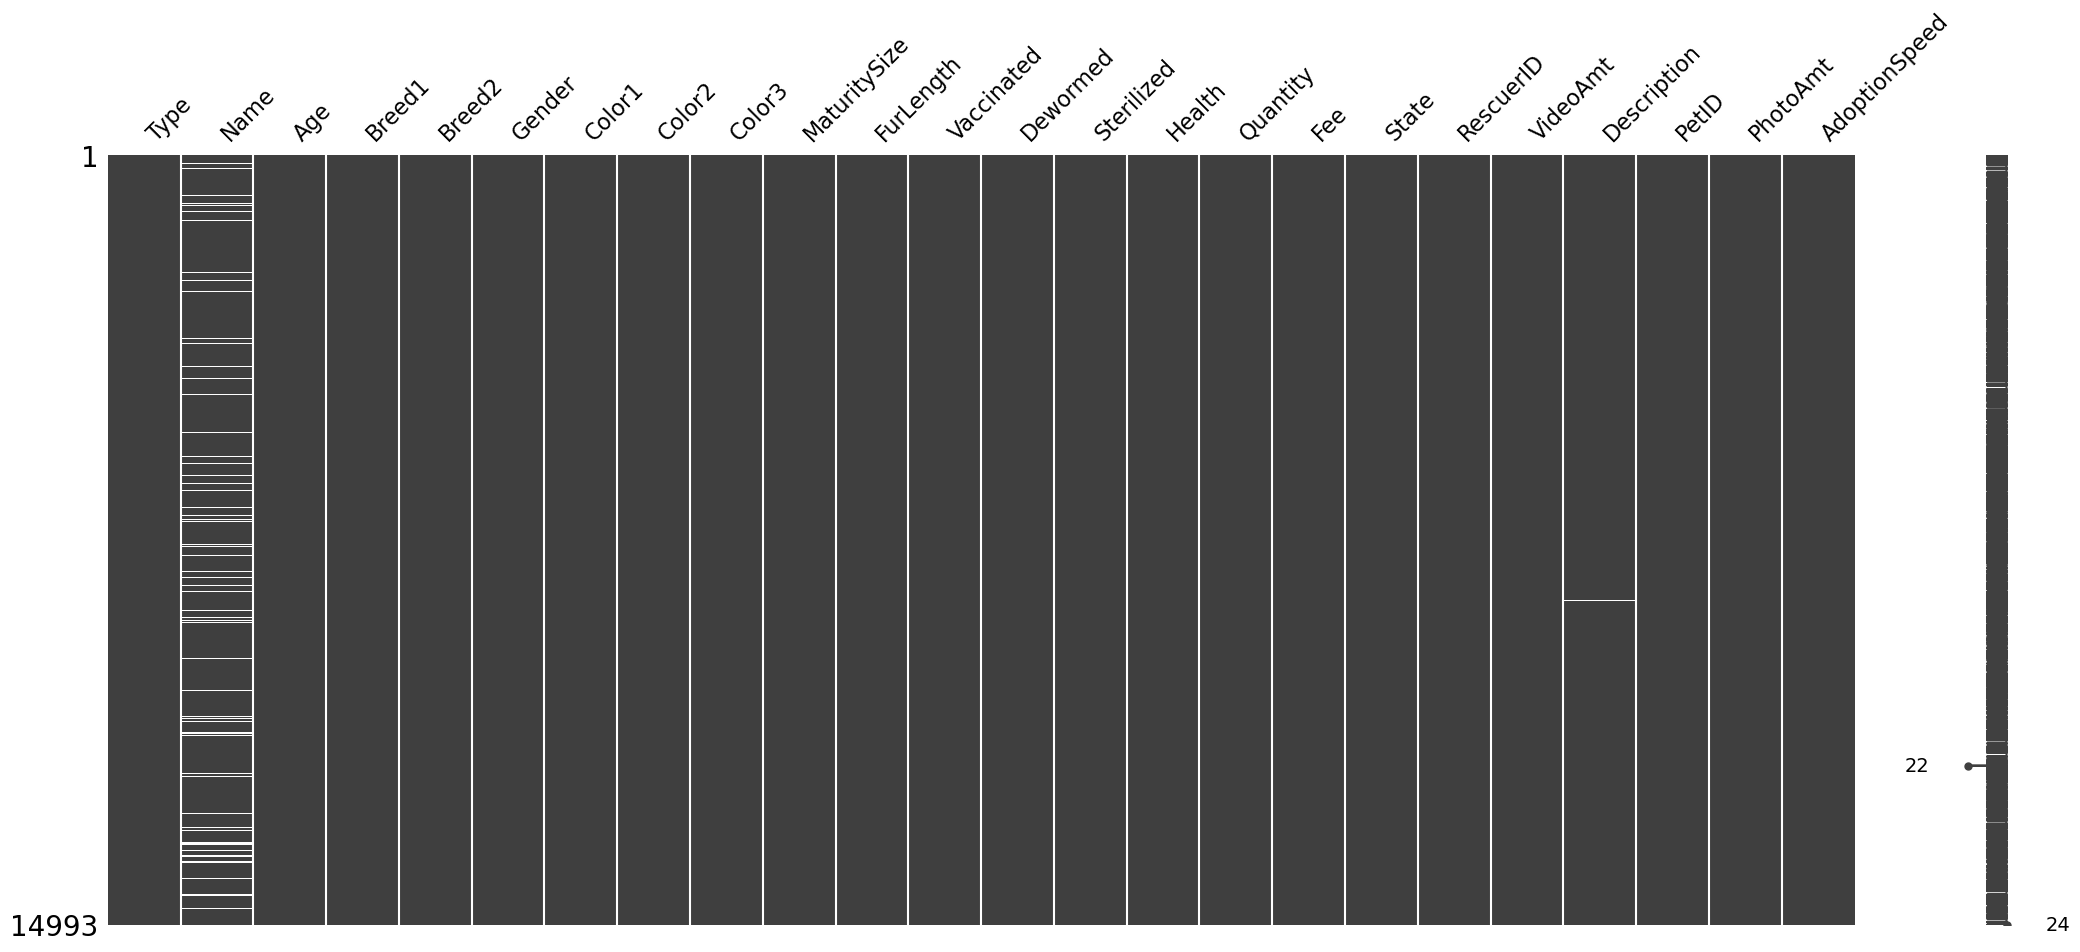

In [8]:
msno.matrix(train)

<Axes: >

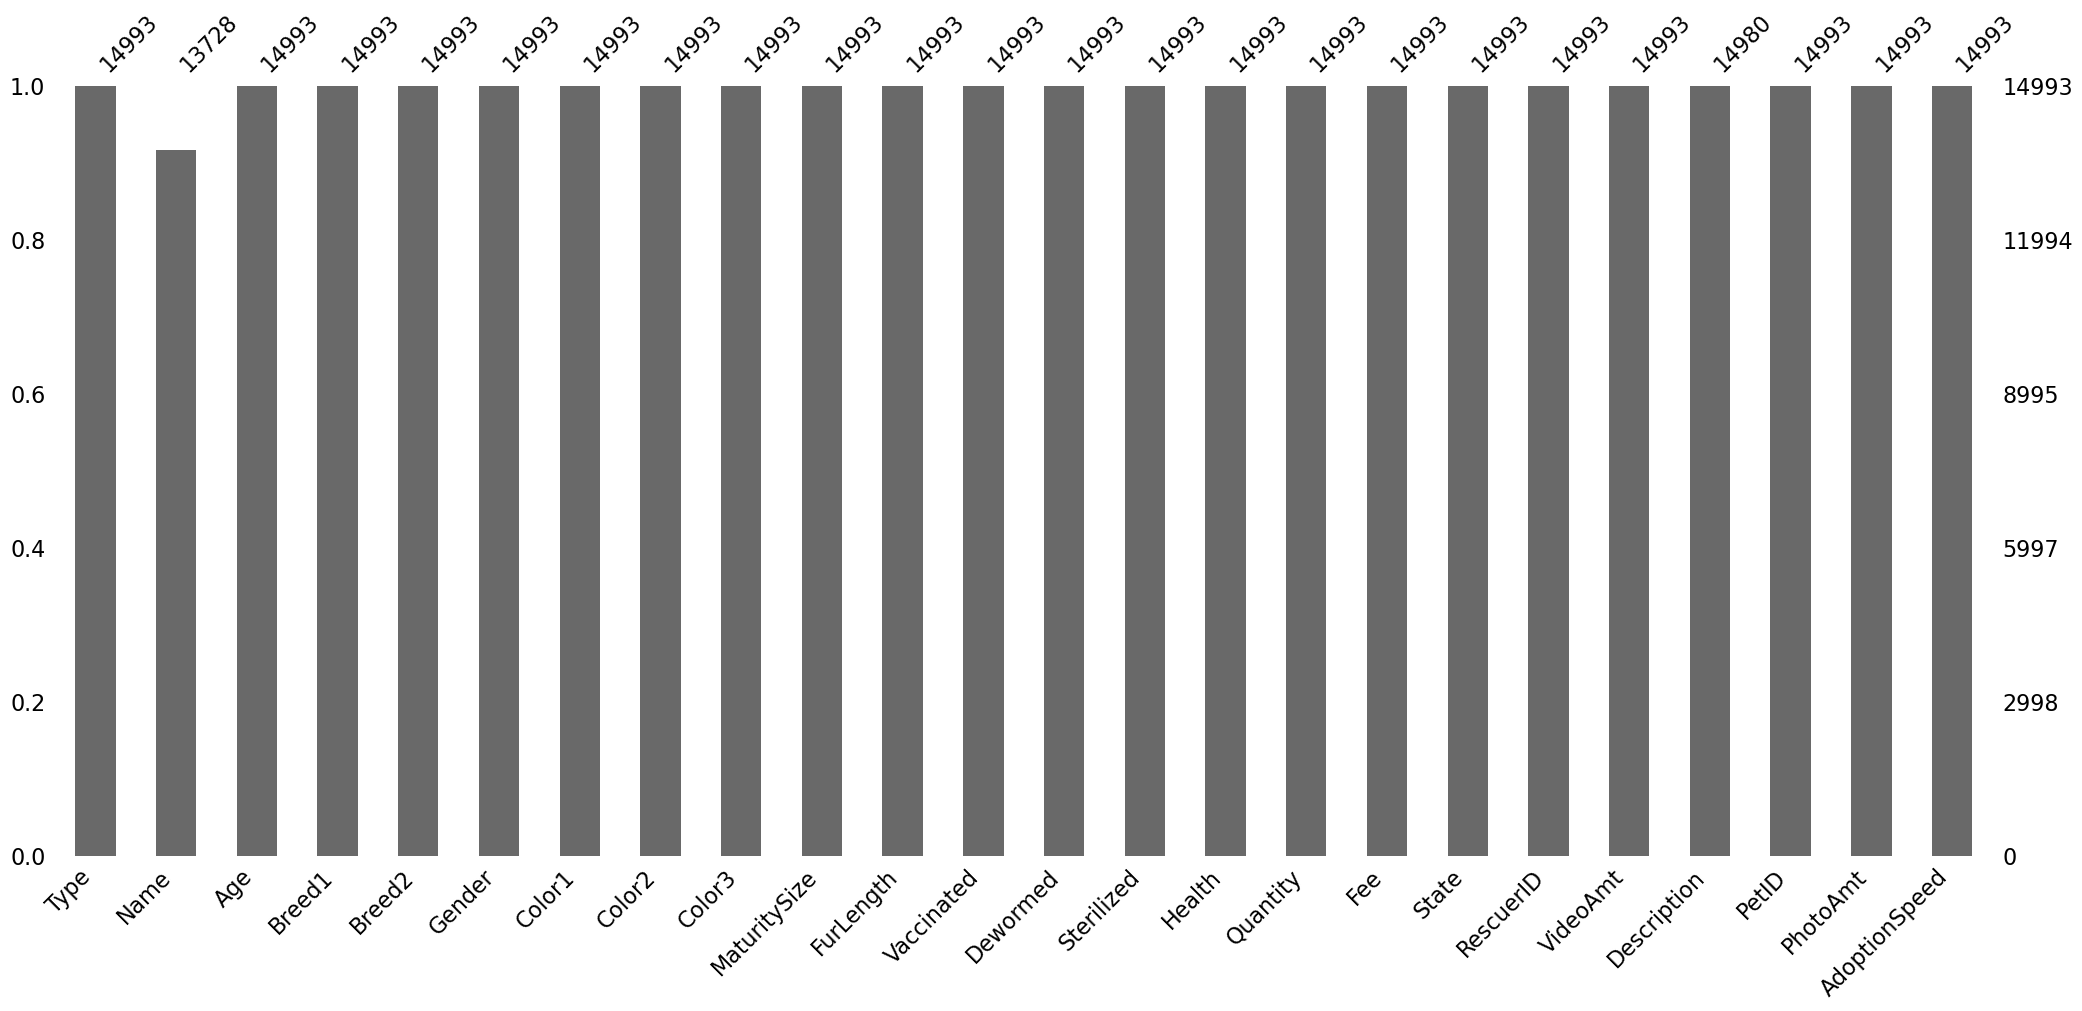

In [9]:
msno.bar(train)

In [10]:
#Se encuentran con valores nulos las variables Name y Description. Name cuenta con 1265 nulos, a lo que debemos sumar las categorizados como "No Name". 
#Debemos hacer posteriormente una limpieza e imputación de strings en la varibale Name. Continua en 4.1 Pre procesamiento.

#### 3.2.2 Inspeccion de variable 'velocidad de adopcion' y si contiene o no 'description'

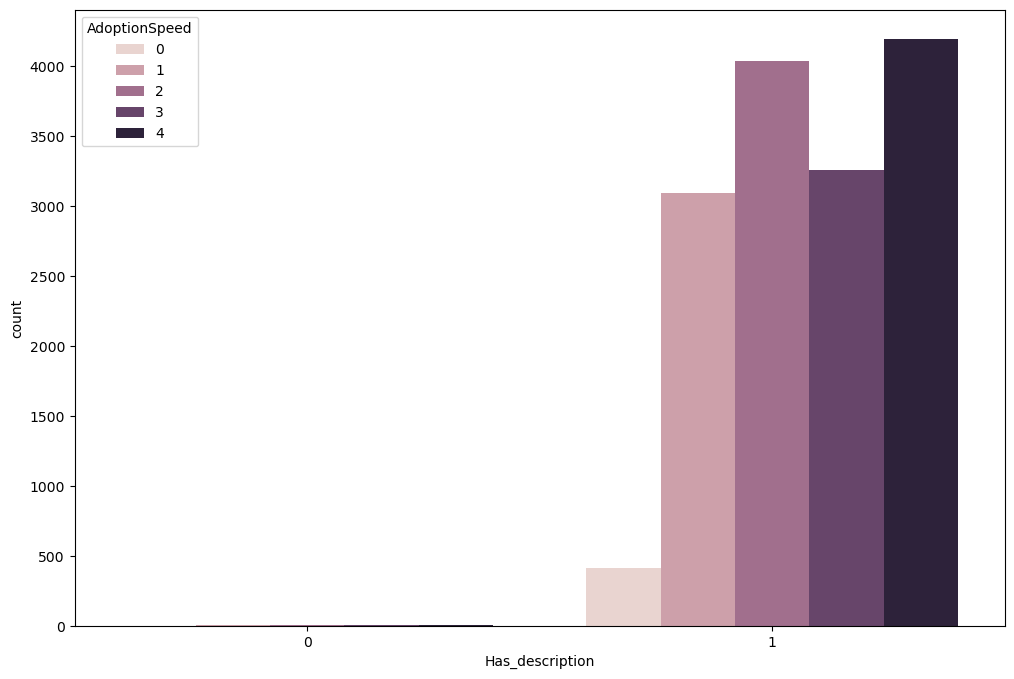

In [14]:
#Gráfico de velocidad de adopcion y si contiene o no descripción:
train['Description'] = train['Description'].fillna('Undescription')
train['Has_description'] = 1
train.loc[train['Description'] == 'Undescription', 'Has_description'] = 0

sns.countplot(x='Has_description', data=train, hue='AdoptionSpeed');

In [ ]:
#La relación entre ambos factores es considerable, por lo que repetimos el estudio sólo para el caso sin descripción.

#### 3.2.3 Inspeccion de variable 'velocidad de adopcion' y ' no description'

<Axes: xlabel='Has_description', ylabel='count'>

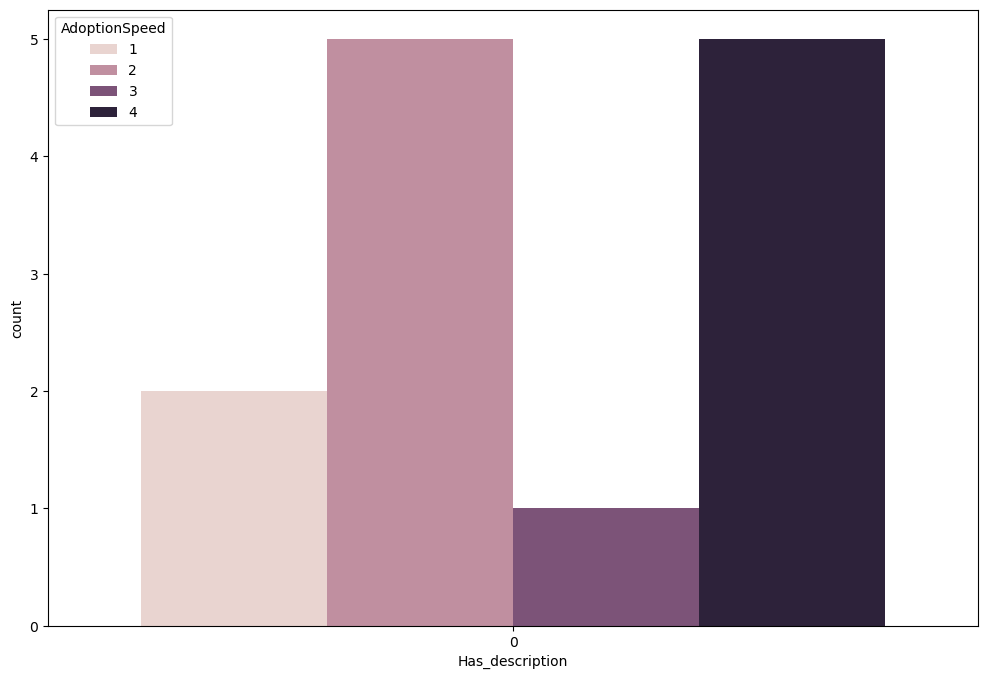

In [15]:
#Gráfico de velocidad de adopcion y no descripción:
#Almacenamos sólo los registros sin descripción
no_description_df = train[train['Has_description'] == 0]

sns.countplot(x='Has_description', data=no_description_df, hue='AdoptionSpeed')


In [ ]:
#La variable Description no parece tener efecto claro en mejorar la velocidad de adopción.

#### 3.2.4 Separamos el dataset en dos, uno para perros y otro para gatos para analizar las razas de cada clase.

In [16]:
# Filtrar los datos de perros y gatos
dogs = train[train['Type'] == 1]
cats = train[train['Type'] == 2]
dogs.head()
cats.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,is_no_name,Has_description
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,False,1
1,2,NoName Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,False,1
5,2,NaN,3,266,0,2,5,6,0,2,1,2,2,2,1,1,0,41326,22fe332bf9c924d4718005891c63fbed,0,This is a stray kitten that came to my house. ...,d24c30b4b,2.0,2,False,1
6,2,BULAT,12,264,264,1,1,0,0,2,3,2,2,3,1,1,300,41326,1e0b5a458b5b77f5af581d57ebf570b3,0,anyone within the area of ipoh or taiping who ...,1caa6fcdb,3.0,1,False,1
8,2,NaN,2,265,0,2,6,0,0,2,2,2,2,2,1,1,0,41326,d8af7afece71334473575c9f70daf00d,0,"healthy and active, feisty kitten found in nei...",c06d167ca,6.0,1,False,1


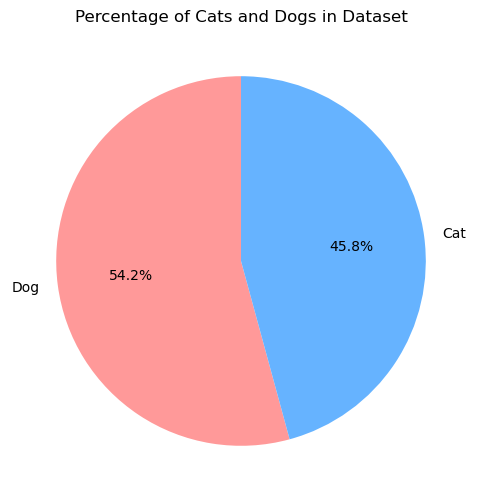

In [17]:
# Realizar el mapeo solo para el propósito del gráfico
type_mapped = train['Type'].map({1: 'Dog', 2: 'Cat'})

# Contar el número de gatos y perros después del mapeo
type_counts = type_mapped.value_counts()
total_count = len(train)

# Calcular el porcentaje
type_percentages = (type_counts / total_count) * 100

# Graficar
plt.figure(figsize=(8, 6))
type_percentages.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Percentage of Cats and Dogs in Dataset')
plt.ylabel('')  # Elimina la etiqueta del eje y
plt.show()


#### 3.2.5 Inspeccion de variable adopciones segun raza

In [18]:
# Contar adopciones por raza para perros
dog_breeds_adopted = dogs.groupby('Breed1')['AdoptionSpeed'].count().reset_index()
dog_breeds_adopted.columns = ['Breed1', 'AdoptionCount']
dog_breeds_adopted = dog_breeds_adopted.sort_values(by='AdoptionCount', ascending=False).head(10)
print(dog_breeds_adopted)

# Contar adopciones por raza para gatos
cat_breeds_adopted = cats.groupby('Breed1')['AdoptionSpeed'].count().reset_index()
cat_breeds_adopted.columns = ['Breed1', 'AdoptionCount']
cat_breeds_adopted = cat_breeds_adopted.sort_values(by='AdoptionCount', ascending=False).head(10)
print(cat_breeds_adopted)

     Breed1  AdoptionCount
115     307           5923
64      141            205
96      205            189
80      179            167
104     218            161
51      109            151
48      103             98
12       20             90
100     213             89
85      189             88
    Breed1  AdoptionCount
29     266           3634
28     265           1258
59     299            342
27     264            296
52     292            264
46     285            221
21     254            105
10     243             94
44     283             73
14     247             71


C:\Users\HOME\AppData\Local\Temp\ipykernel_10220\994912139.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Breed1', y='AdoptionCount', data=dog_breeds_adopted, palette='viridis')


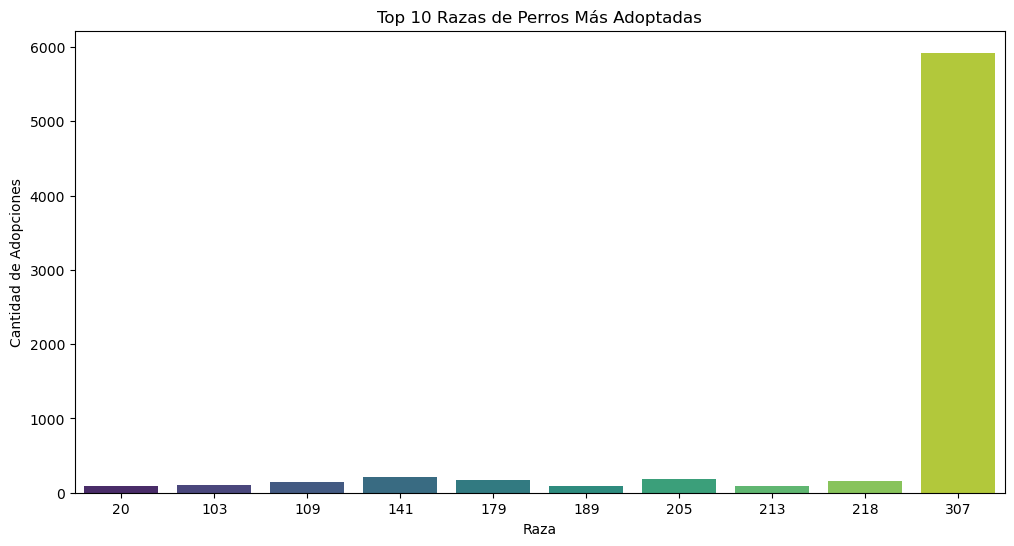

C:\Users\HOME\AppData\Local\Temp\ipykernel_10220\994912139.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Breed1', y='AdoptionCount', data=cat_breeds_adopted, palette='magma')


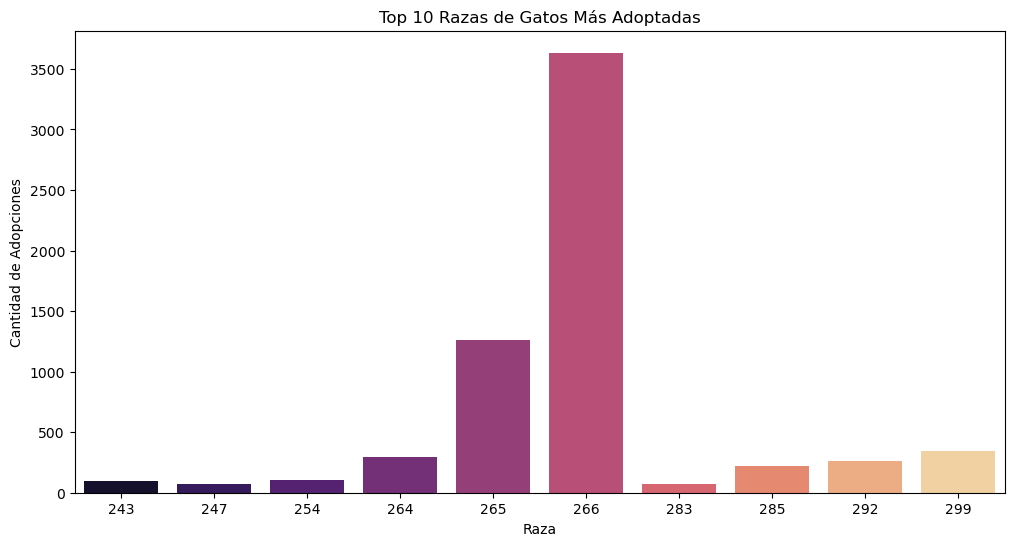

In [19]:

# Gráfico de las razas más adoptadas para perros según Breed1

plt.figure(figsize=(12, 6))

sns.barplot(x='Breed1', y='AdoptionCount', data=dog_breeds_adopted, palette='viridis')

plt.title('Top 10 Razas de Perros Más Adoptadas')

plt.xlabel('Raza')

plt.ylabel('Cantidad de Adopciones')

plt.show()
 
# Gráfico de las razas más adoptadas para gatos

plt.figure(figsize=(12, 6))

sns.barplot(x='Breed1', y='AdoptionCount', data=cat_breeds_adopted, palette='magma')

plt.title('Top 10 Razas de Gatos Más Adoptadas')

plt.xlabel('Raza')

plt.ylabel('Cantidad de Adopciones')

plt.show()


In [ ]:
#Perros:
#Encontramos el label 307 (Mestizo) como la raza mas popular en el dataset.

#Gatos:
#Encontramos el label 266 (Domestic Short Hair) como la raza mas popular en el dataset.

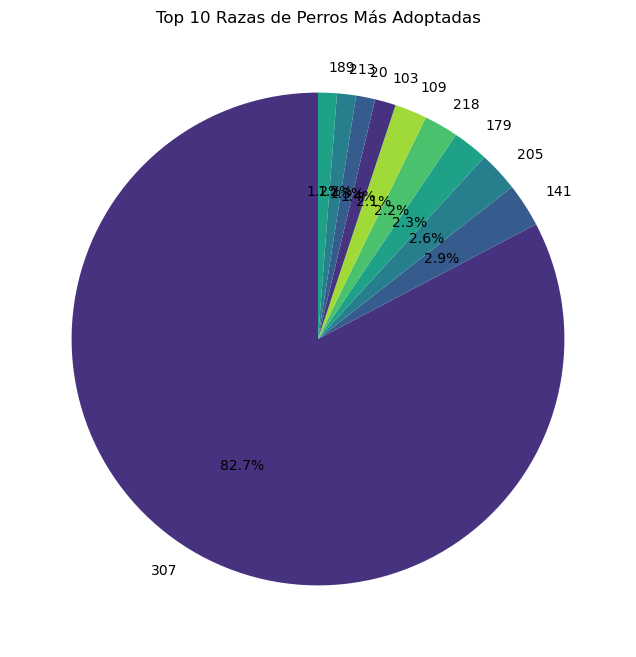

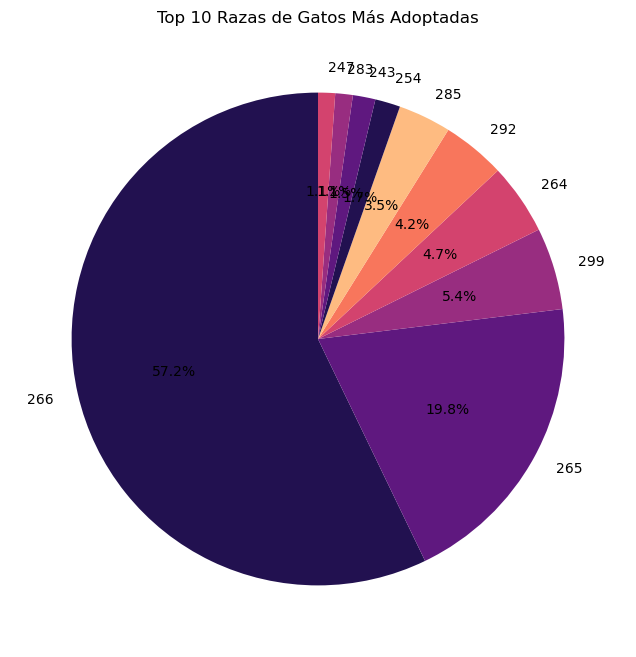

In [20]:
#Observmaos en un grafico de torta la distribución de las razas más populares en el dataset para perros y para gatos:

# Gráfico de torta de las razas más adoptadas para perros

plt.figure(figsize=(8, 8))

plt.pie(dog_breeds_adopted['AdoptionCount'], labels=dog_breeds_adopted['Breed1'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis'))

plt.title('Top 10 Razas de Perros Más Adoptadas')

plt.show()

# Gráfico de torta de las razas más adoptadas para gatos

plt.figure(figsize=(8, 8))

plt.pie(cat_breeds_adopted['AdoptionCount'], labels=cat_breeds_adopted['Breed1'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('magma'))

plt.title('Top 10 Razas de Gatos Más Adoptadas')

plt.show()

#### 3.2.6 Inspeccion de variable color de las mascotas

In [21]:
#Analizamos los colores de las mascotas (Color 1, Color 2, Color 3)
# Contar la frecuencia de cada color en cada columna

color1_counts = train['Color1'].value_counts()

color2_counts = train['Color2'].value_counts()

color3_counts = train['Color3'].value_counts()
 
# Imprimir los resultados

print("Frecuencia de cada color en Color1:")

print(color1_counts)

print("\nFrecuencia de cada color en Color2:")

print(color2_counts)

print("\nFrecuencia de cada color en Color3:")

print(color3_counts)

# Crear una columna para la combinación de colores

train['ColorCombination'] = train[['Color1', 'Color2', 'Color3']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
 
# Contar las combinaciones de colores más comunes

color_combination_counts = train['ColorCombination'].value_counts().head(10)
 
# Imprimir los resultados

print("\nCombinaciones de colores más comunes:")

print(color_combination_counts)


Frecuencia de cada color en Color1:
Color1
1    7427
2    3750
3     947
5     884
6     684
7     667
4     634
Name: count, dtype: int64

Frecuencia de cada color en Color2:
Color2
0    4471
7    3438
2    3313
5    1128
6    1063
4     870
3     710
Name: count, dtype: int64

Frecuencia de cada color en Color3:
Color3
0    10604
7     3221
5      417
6      378
4      198
3      175
Name: count, dtype: int64

Combinaciones de colores más comunes:
ColorCombination
2_0_0    1460
1_2_0    1417
1_7_0    1375
1_2_7    1159
1_0_0    1002
2_7_0     929
7_0_0     667
5_0_0     483
1_6_7     449
6_7_0     377
Name: count, dtype: int64


C:\Users\HOME\AppData\Local\Temp\ipykernel_10220\2642032814.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=color1_counts.index, y=color1_counts.values, palette='viridis')


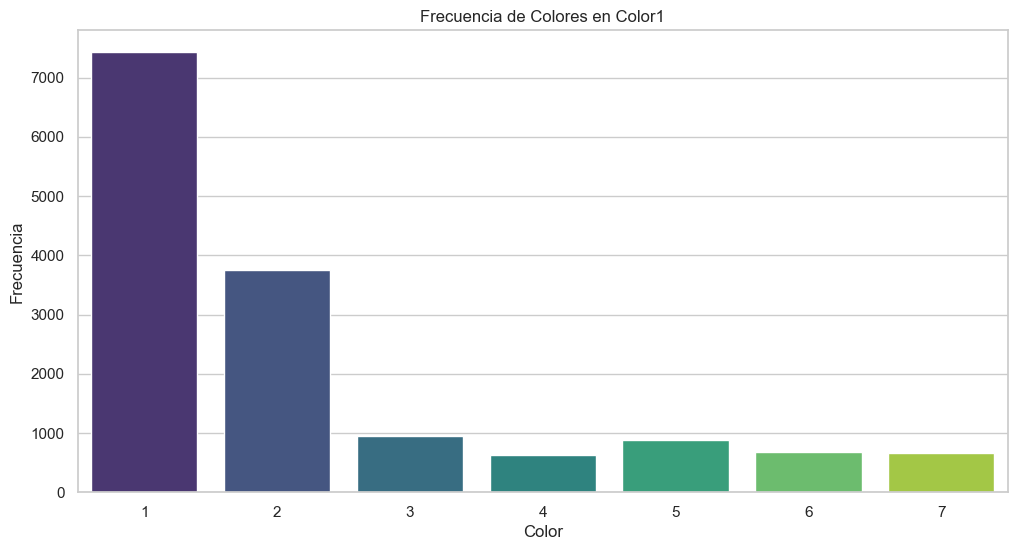

C:\Users\HOME\AppData\Local\Temp\ipykernel_10220\2642032814.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=color2_counts.index, y=color2_counts.values, palette='magma')


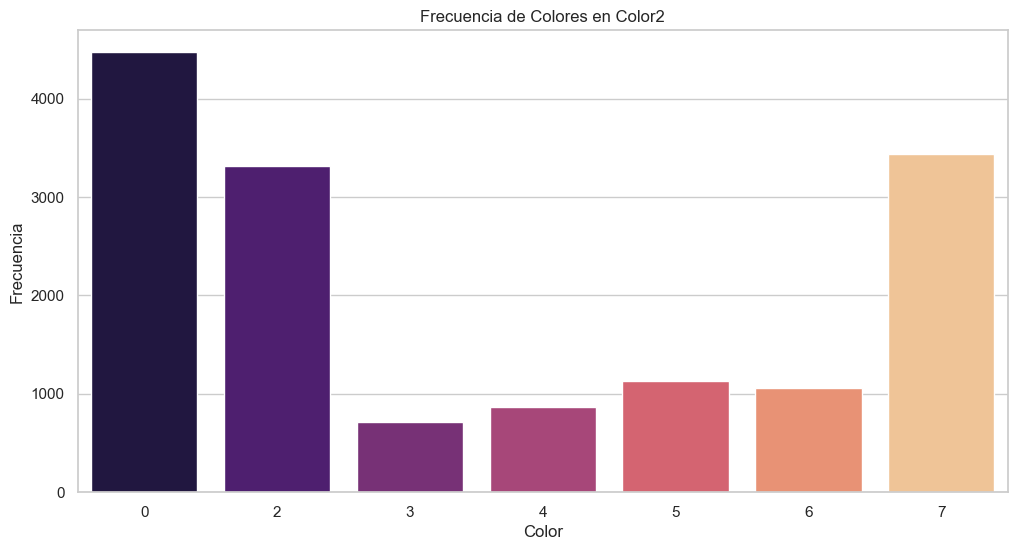

C:\Users\HOME\AppData\Local\Temp\ipykernel_10220\2642032814.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=color3_counts.index, y=color3_counts.values, palette='plasma')


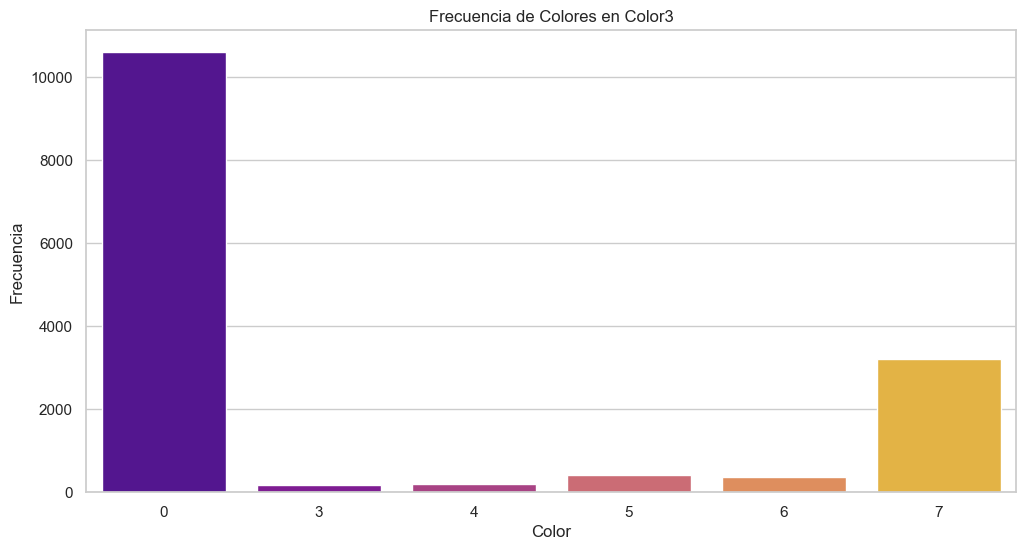

C:\Users\HOME\AppData\Local\Temp\ipykernel_10220\2642032814.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=color_combination_counts.index, y=color_combination_counts.values, palette='cubehelix')


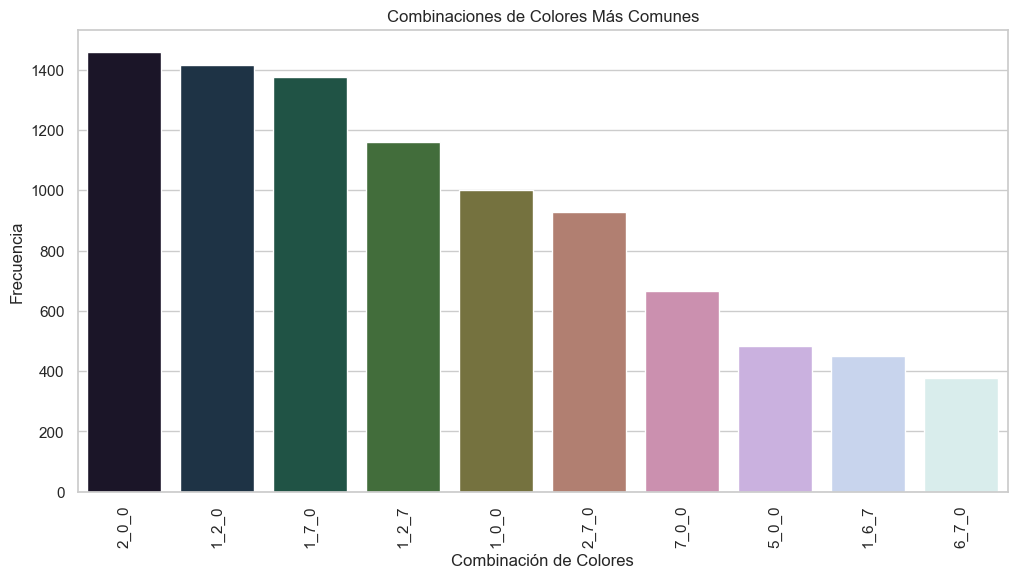

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
 
# Configuración de las visualizaciones
sns.set(style="whitegrid")
 
# Frecuencia de cada color en Color1
plt.figure(figsize=(12, 6))
sns.barplot(x=color1_counts.index, y=color1_counts.values, palette='viridis')
plt.title('Frecuencia de Colores en Color1')
plt.xlabel('Color')
plt.ylabel('Frecuencia')
plt.show()
 
# Frecuencia de cada color en Color2
plt.figure(figsize=(12, 6))
sns.barplot(x=color2_counts.index, y=color2_counts.values, palette='magma')
plt.title('Frecuencia de Colores en Color2')
plt.xlabel('Color')
plt.ylabel('Frecuencia')
plt.show()
 
# Frecuencia de cada color en Color3
plt.figure(figsize=(12, 6))
sns.barplot(x=color3_counts.index, y=color3_counts.values, palette='plasma')
plt.title('Frecuencia de Colores en Color3')
plt.xlabel('Color')
plt.ylabel('Frecuencia')
plt.show()
 
# Combinaciones de colores más comunes
plt.figure(figsize=(12, 6))
sns.barplot(x=color_combination_counts.index, y=color_combination_counts.values, palette='cubehelix')
plt.title('Combinaciones de Colores Más Comunes')
plt.xlabel('Combinación de Colores')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.show()

#tiene menú contextual

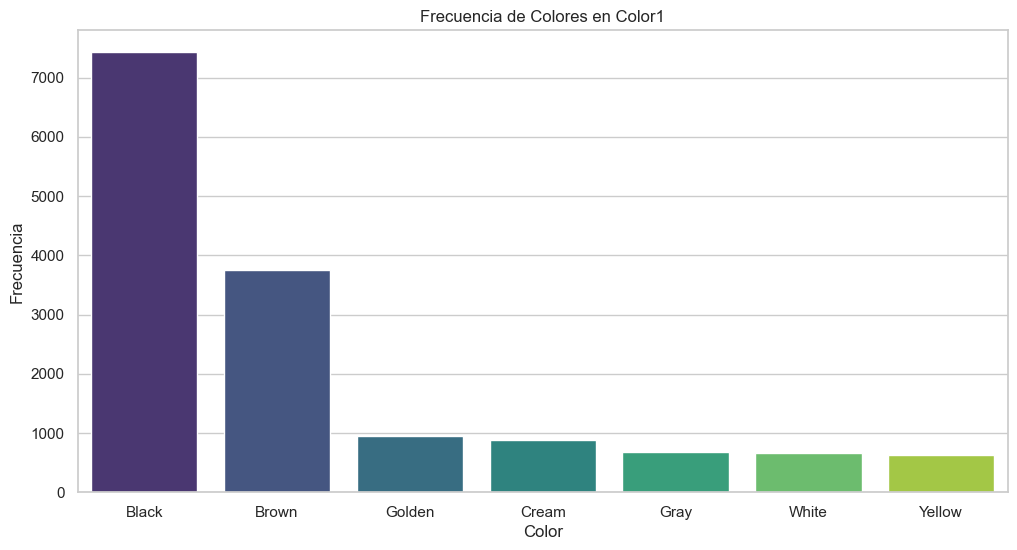

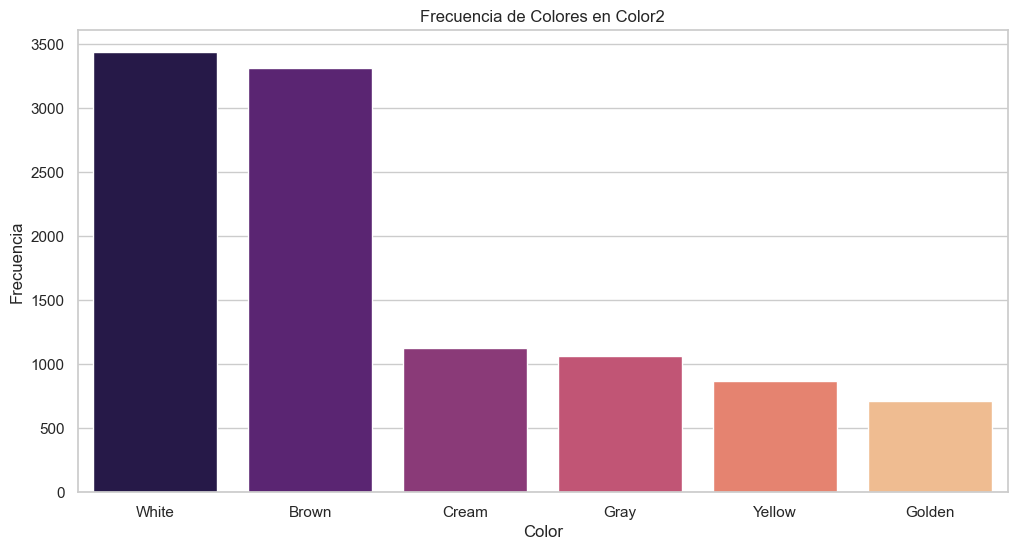

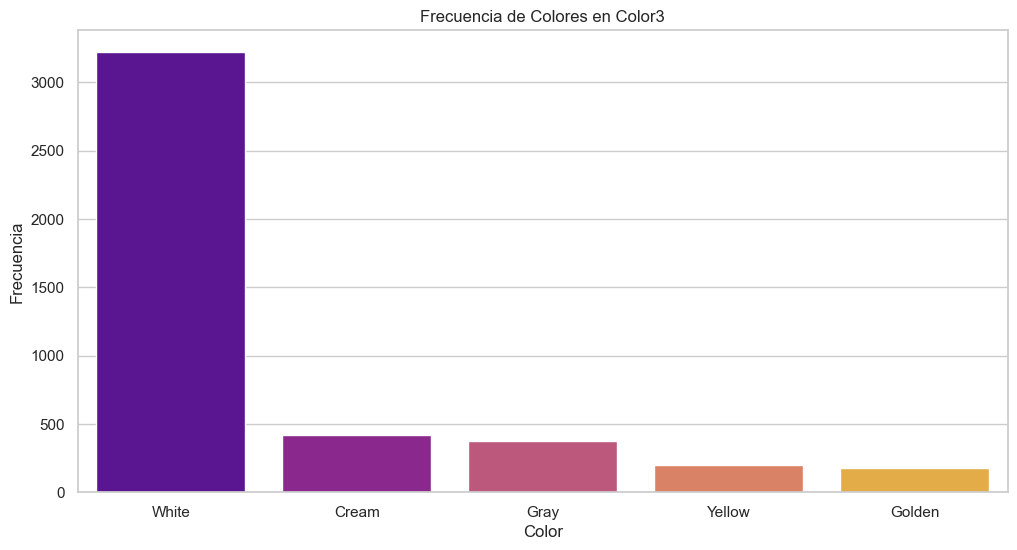

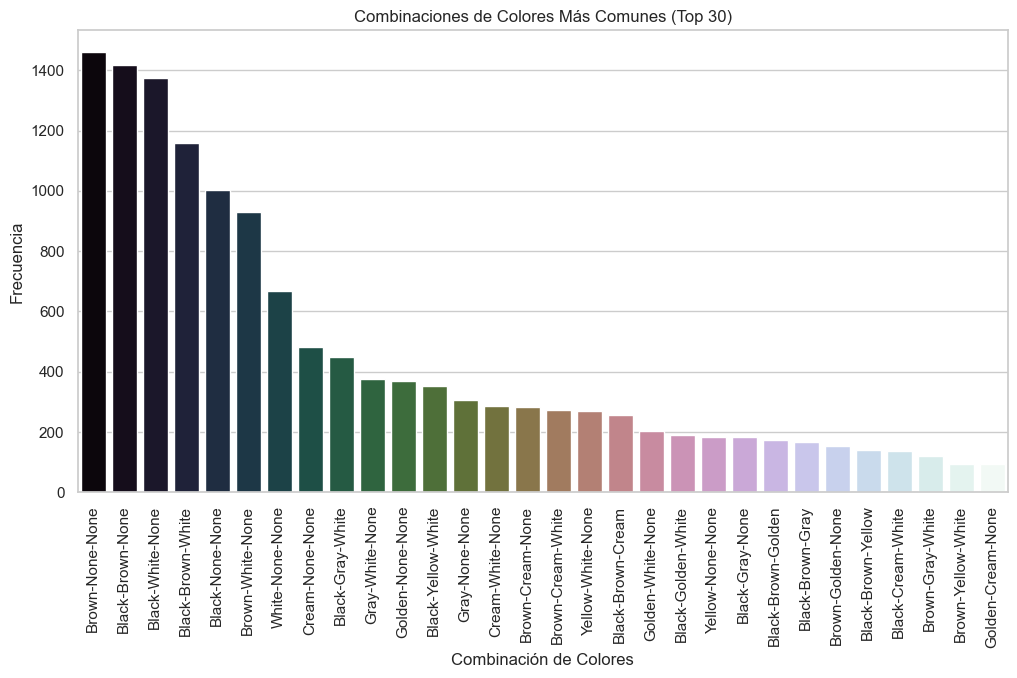

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de las visualizaciones
sns.set(style="whitegrid")

# Contar la frecuencia de cada valor en Color1 y hacer merge temporal para obtener los nombres de colores
color1_counts = train['Color1'].value_counts().reset_index()
color1_counts.columns = ['ColorID', 'Count']
color1_counts = color1_counts.merge(colors, how='left', left_on='ColorID', right_on='ColorID')

# Contar la frecuencia de cada valor en Color2 y hacer merge temporal para obtener los nombres de colores
color2_counts = train['Color2'].value_counts().reset_index()
color2_counts.columns = ['ColorID', 'Count']
color2_counts = color2_counts.merge(colors, how='left', left_on='ColorID', right_on='ColorID')

# Contar la frecuencia de cada valor en Color3 y hacer merge temporal para obtener los nombres de colores
color3_counts = train['Color3'].value_counts().reset_index()
color3_counts.columns = ['ColorID', 'Count']
color3_counts = color3_counts.merge(colors, how='left', left_on='ColorID', right_on='ColorID')

# Frecuencia de cada color en Color1
plt.figure(figsize=(12, 6))
sns.barplot(x='ColorName', y='Count', data=color1_counts, palette='viridis', hue='ColorName', dodge=False, legend=False)
plt.title('Frecuencia de Colores en Color1')
plt.xlabel('Color')
plt.ylabel('Frecuencia')
plt.show()

# Frecuencia de cada color en Color2
plt.figure(figsize=(12, 6))
sns.barplot(x='ColorName', y='Count', data=color2_counts, palette='magma', hue='ColorName', dodge=False, legend=False)
plt.title('Frecuencia de Colores en Color2')
plt.xlabel('Color')
plt.ylabel('Frecuencia')
plt.show()

# Frecuencia de cada color en Color3
plt.figure(figsize=(12, 6))
sns.barplot(x='ColorName', y='Count', data=color3_counts, palette='plasma', hue='ColorName', dodge=False, legend=False)
plt.title('Frecuencia de Colores en Color3')
plt.xlabel('Color')
plt.ylabel('Frecuencia')
plt.show()

# Combinaciones de colores más comunes
train = train.merge(colors[['ColorID', 'ColorName']], how='left', left_on='Color1', right_on='ColorID', suffixes=('', '_Color1'))
train = train.rename(columns={'ColorName': 'Color1_Name'})
train = train.drop(columns='ColorID')

train = train.merge(colors[['ColorID', 'ColorName']], how='left', left_on='Color2', right_on='ColorID', suffixes=('', '_Color2'))
train = train.rename(columns={'ColorName': 'Color2_Name'})
train = train.drop(columns='ColorID')

train = train.merge(colors[['ColorID', 'ColorName']], how='left', left_on='Color3', right_on='ColorID', suffixes=('', '_Color3'))
train = train.rename(columns={'ColorName': 'Color3_Name'})
train = train.drop(columns='ColorID')

# Asegurar que las columnas de nombres de colores estén correctamente alineadas y manejar valores faltantes
train['Color1_Name'] = train['Color1_Name'].fillna('None')
train['Color2_Name'] = train['Color2_Name'].fillna('None')
train['Color3_Name'] = train['Color3_Name'].fillna('None')

# Crear la columna de combinaciones de colores
train['Color_Combination'] = train['Color1_Name'] + '-' + train['Color2_Name'] + '-' + train['Color3_Name']

# Contar las combinaciones de colores
color_combination_counts = train['Color_Combination'].value_counts().reset_index()
color_combination_counts.columns = ['Color_Combination', 'Count']

# Limitar a las 30 combinaciones más comunes
top_30_combinations = color_combination_counts.head(30)

# Visualizar las combinaciones de colores más comunes
plt.figure(figsize=(12, 6))
sns.barplot(x='Color_Combination', y='Count', data=top_30_combinations, palette='cubehelix', hue='Color_Combination', dodge=False, legend=False)
plt.title('Combinaciones de Colores Más Comunes (Top 30)')
plt.xlabel('Combinación de Colores')
plt.ylabel('Frecuencia')
plt.xticks(rotation=90)
plt.show()


In [ ]:
#Se observa que la combinación de colores más popular del dataset (perros y gatos juntos), es la combinación de colores 2_0_0, que corresponde a color Brown (Marrón). 
#Se evaluará en 5.1 armar una nueva variable de colores puros.

#### 3.2.7 Inspeccion de variable Vacunación y su velocidad de adopción

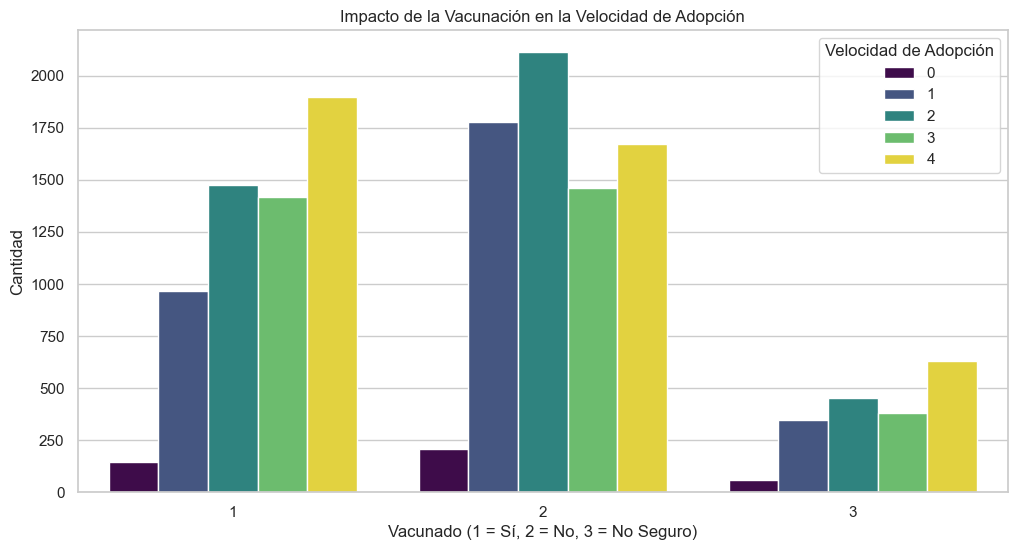

In [24]:
#Variables de salud: Vaccinated
#Factores 1=si, 2=no, 3=no se sabe

# Configuración de las visualizaciones
sns.set(style="whitegrid")
 
# Crear un gráfico de conteo (countplot) para visualizar la relación entre 'Vaccinated' y 'AdoptionSpeed'
plt.figure(figsize=(12, 6))
sns.countplot(x='Vaccinated', data=train, hue='AdoptionSpeed', palette='viridis')
plt.title('Impacto de la Vacunación en la Velocidad de Adopción')
plt.xlabel('Vacunado (1 = Sí, 2 = No, 3 = No Seguro)')
plt.ylabel('Cantidad')
plt.legend(title='Velocidad de Adopción', loc='upper right')
plt.show()

C:\Users\HOME\AppData\Local\Temp\ipykernel_10220\4105340723.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Vaccinated', data=adopted_in_0, palette='viridis')


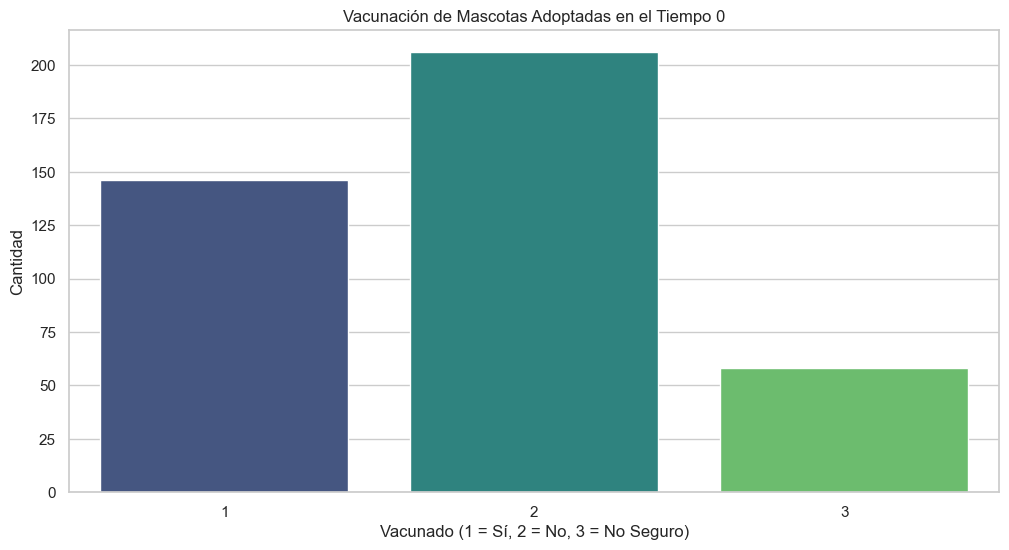

In [25]:
#Ahora verificamos la relación de mascotas adoptadas a tiempo 0 solamente y la variable Vaccinated:

# Filtrar los datos para obtener solo las mascotas adoptadas en el tiempo 0
adopted_in_0 = train[train['AdoptionSpeed'] == 0]

# Crear un gráfico de conteo (countplot) para visualizar la relación entre 'Vaccinated' y 'AdoptionSpeed'
plt.figure(figsize=(12, 6))
sns.countplot(x='Vaccinated', data=adopted_in_0, palette='viridis')
plt.title('Vacunación de Mascotas Adoptadas en el Tiempo 0')
plt.xlabel('Vacunado (1 = Sí, 2 = No, 3 = No Seguro)')
plt.ylabel('Cantidad')
plt.show()



In [26]:
#ahora lo vemos en cuadro de frecuencias relativas para comparar

# Calcular la frecuencia relativa de mascotas adoptadas en el tiempo 0 para cada valor de 'Vaccinated'  
vaccinated_counts = adopted_in_0['Vaccinated'].value_counts(normalize=True)

# Imprimir los resultados
print(vaccinated_counts)


Vaccinated
2    0.502439
1    0.356098
3    0.141463
Name: proportion, dtype: float64


In [ ]:
#A partir de los gráficos de vacunación y velocidad de adopción, no parece observarse una relación clara entre la vacunación efectiva y la velocidad de adopción. 
#Los cachorros tienen corta edad y aún no están vacunados, este efecto puede influir sobre la preferencia de adopción de los mismos, pese a no estar vacunados.

#### 3.2.8 Inspeccion de variable Desparasitación y su velocidad de adopción

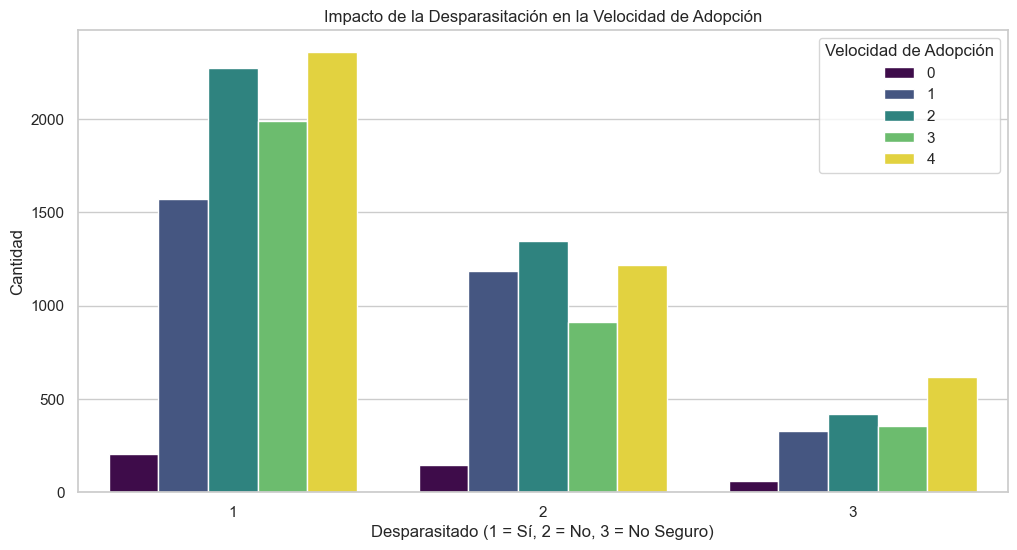

In [27]:
#Variables de salud: Dewormed
#Factores 1=si, 2=no, 3=no se sabe

# Configuración de las visualizaciones
sns.set(style="whitegrid")
 
# Crear un gráfico de conteo (countplot) para visualizar la relación entre 'Dewormed' y 'AdoptionSpeed'
plt.figure(figsize=(12, 6))
sns.countplot(x='Dewormed', data=train, hue='AdoptionSpeed', palette='viridis')
plt.title('Impacto de la Desparasitación en la Velocidad de Adopción')
plt.xlabel('Desparasitado (1 = Sí, 2 = No, 3 = No Seguro)')
plt.ylabel('Cantidad')
plt.legend(title='Velocidad de Adopción', loc='upper right')
plt.show()


In [ ]:
#A partir de los graficos de desparasitación y velocidad de adopción, no parece observarse una relación clara entre la desparasitación efectiva y la velocidad de adopción. 
#Los cachorros tienen corta edad y aún no están desparasitados, este efecto puede influir sobre la preferencia de adopción de los mismos, pese a no estar desparasitados.

#### 3.2.9 Inspeccion de variable Esterilización y su velocidad de adopción

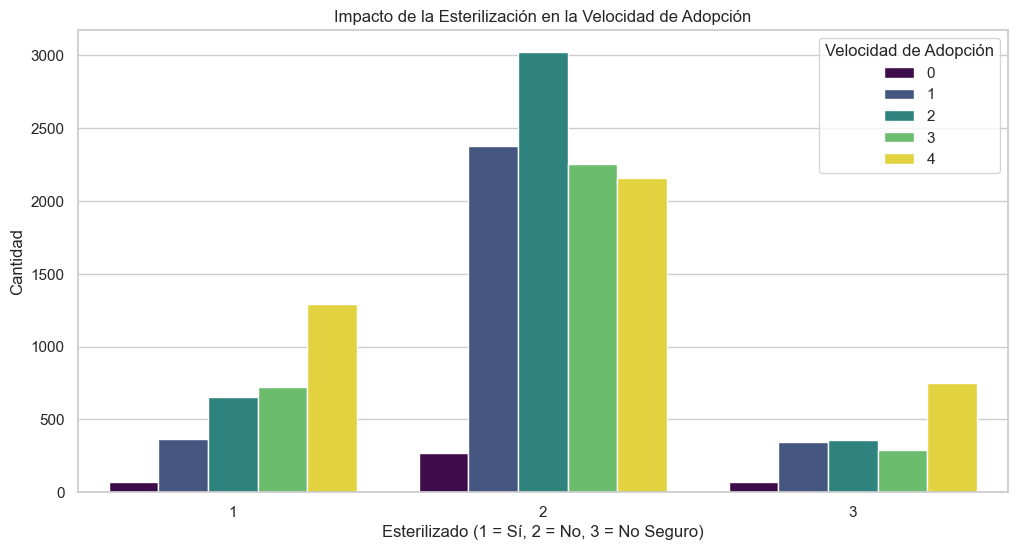

In [28]:
#Variables de salud: Sterilized
#Factores 1=si, 2=no, 3=no se sabe

# Configuración de las visualizaciones
sns.set(style="whitegrid")
 
# Crear un gráfico de conteo (countplot) para visualizar la relación entre 'Sterilized' y 'AdoptionSpeed'
plt.figure(figsize=(12, 6))
sns.countplot(x='Sterilized', data=train, hue='AdoptionSpeed', palette='viridis')
plt.title('Impacto de la Esterilización en la Velocidad de Adopción')
plt.xlabel('Esterilizado (1 = Sí, 2 = No, 3 = No Seguro)')
plt.ylabel('Cantidad')
plt.legend(title='Velocidad de Adopción', loc='upper right')
plt.show()

In [ ]:
#A partir de los graficos de esterilización y velocidad de adopción, no parece observarse una relación clara entre la esterilización efectiva y la velocidad de adopción. 
#Los cachorros tienen corta edad y aún no están esterilizados, este efecto puede influir sobre la preferencia de adopción de los mismos, pese a no estar esterilizados.

#### 3.2.10 Inspeccion de variable Salud

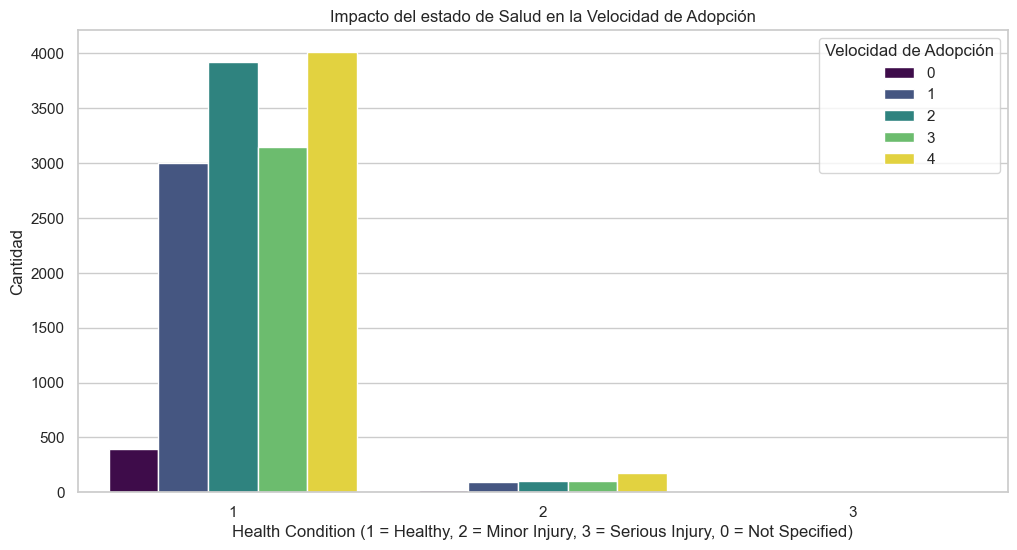

In [29]:
#Variables de salud: Health
#Factores Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)

# Configuración de las visualizaciones
sns.set(style="whitegrid")
 
# Crear un gráfico de conteo (countplot) para visualizar la relación entre 'Health' y 'AdoptionSpeed'
plt.figure(figsize=(12, 6))
sns.countplot(x='Health', data=train, hue='AdoptionSpeed', palette='viridis')
plt.title('Impacto del estado de Salud en la Velocidad de Adopción')
plt.xlabel('Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)')
plt.ylabel('Cantidad')
plt.legend(title='Velocidad de Adopción', loc='upper right')
plt.show()

In [ ]:
#La variable salud no parece tener un impacto significativo en la velocidad de adopción. 
#Es mas, el desbalance entre las tres categorías de salud es tal, que saludables sigue el mismo perfil de velocidades de adopción del dataset completo.

#### 3.2.11 Inspeccion de variable Fee y su velocidad de adopción

C:\Users\HOME\AppData\Local\Temp\ipykernel_10220\3908521813.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='AdoptionSpeed', y='Fee', data=train, palette='magma')


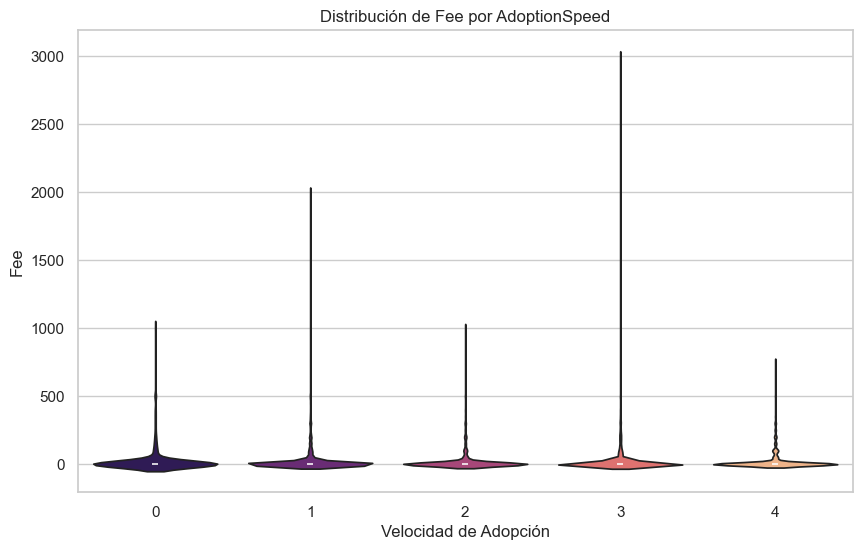

In [30]:
#Observamos el efecto de Fee en las adopciones
# Configuración de las visualizaciones
plt.figure(figsize=(10, 6))
sns.violinplot(x='AdoptionSpeed', y='Fee', data=train, palette='magma')
plt.title('Distribución de Fee por AdoptionSpeed')
plt.xlabel('Velocidad de Adopción')
plt.ylabel('Fee')
plt.show()


In [ ]:
#El gráfico de violines muestra gran asimetría y posible presencia de valores atípicos/outliers para todas las velocidades de adopción.

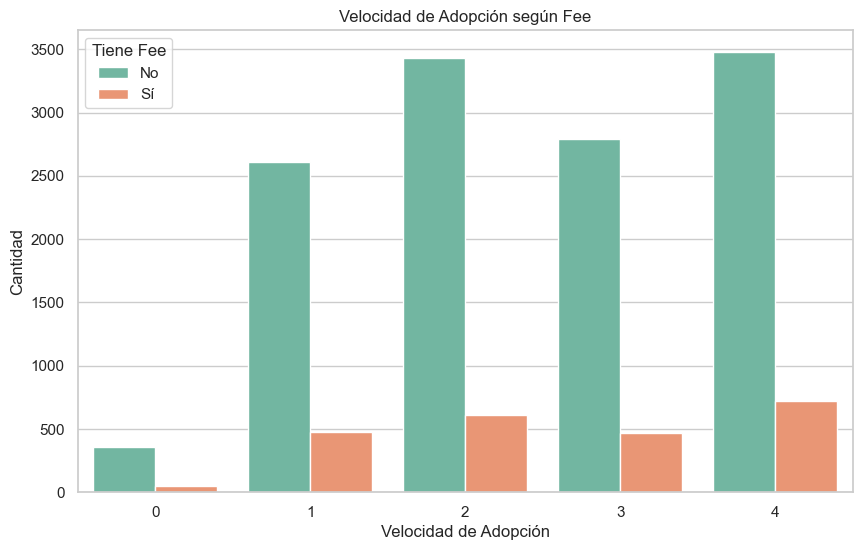

In [31]:
#Verificamos el comportamiento con y sin Fee
# Crear una columna 'Has_fee' para indicar si hay o no fee
train['Has_fee'] = train['Fee'] > 0
 
# Configurar las visualizaciones
plt.figure(figsize=(10, 6))
sns.countplot(x='AdoptionSpeed', data=train, hue='Has_fee', palette='Set2')
plt.title('Velocidad de Adopción según Fee')
plt.xlabel('Velocidad de Adopción')
plt.ylabel('Cantidad')
plt.legend(title='Tiene Fee', labels=['No', 'Sí'])
plt.show()


In [ ]:
#La cantidad de adopciones con el factor "sin Fee" es mayoritaria para todas las velocidades de adopción.

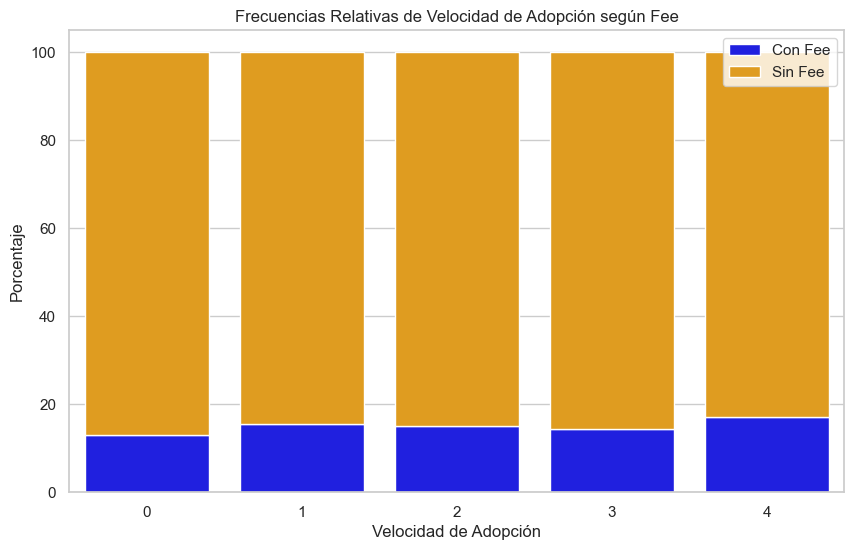

In [32]:
# Crear una columna 'Has_fee' para indicar si hay o no fee
train['Has_fee'] = train['Fee'] > 0
 
# Calcular las frecuencias relativas al 100%
freq_table = pd.crosstab(train['AdoptionSpeed'], train['Has_fee'], normalize='index') * 100

# Crear el gráfico de barras apiladas al 100%
plt.figure(figsize=(10, 6))
sns.barplot(x=freq_table.index, y=freq_table[True], color='blue', label='Con Fee')
sns.barplot(x=freq_table.index, y=freq_table[False], color='orange', bottom=freq_table[True], label='Sin Fee')
plt.title('Frecuencias Relativas de Velocidad de Adopción según Fee')
plt.xlabel('Velocidad de Adopción')
plt.ylabel('Porcentaje')
plt.legend()
plt.show()



In [ ]:
#El índice de adopción relativo de las mascotas sin Fee es mayoritario, para cualquier velocidad de adopción. 
#Resulta más exitoso a los fines de adopción, que sea sin Fee. Y no se observan grandes diferencias relativas en cuanto a las distintas velocidades de adopción 
#(el porcentaje de adopciones sin Fee se mantiene aprox. constante).

#### 3.2.12 Inspeccion de variable regiones por estados 

C:\Users\HOME\AppData\Local\Temp\ipykernel_10220\593163955.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='State', data=train, palette='viridis', order=train['State'].value_counts().index)


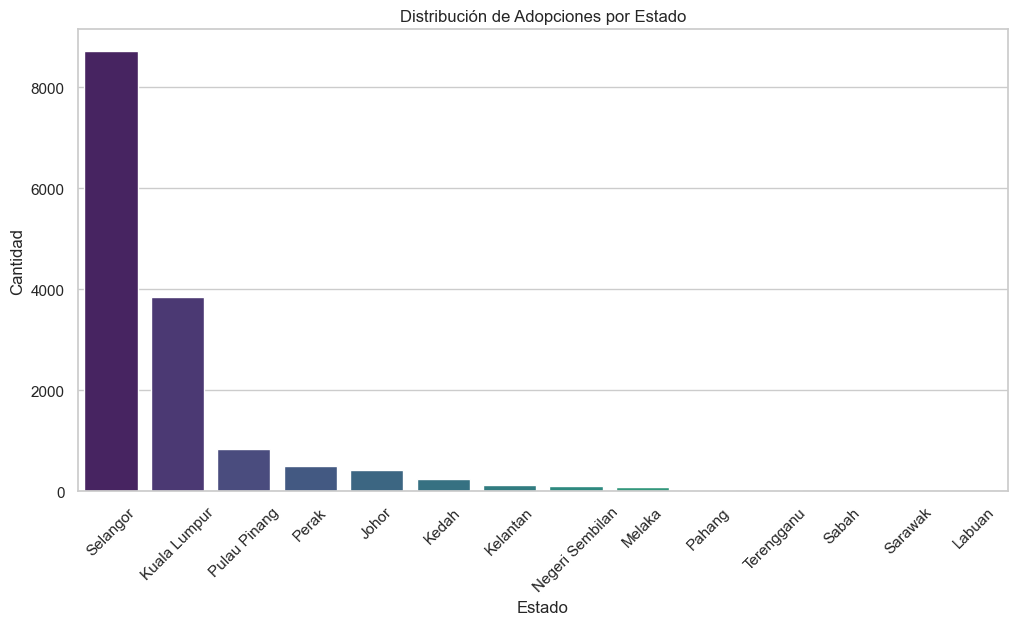

In [33]:
#Estudiamos las regiones geográficas:
#Graficamos la distribución de adopciones por región
#Indicamos los nombres de los Estados
#Ajustamos la etiqueta del eje x para visualizar los nombre de cada estado
#Ordenamos el grafico en eje x de forma descendente

# Configuración de las visualizaciones
plt.figure(figsize=(12, 6))
sns.countplot(x='State', data=train, palette='viridis', order=train['State'].value_counts().index)
plt.title('Distribución de Adopciones por Estado')
plt.xlabel('Estado')
plt.ylabel('Cantidad')
plt.xticks(ticks=range(14), labels=['Selangor', 'Kuala Lumpur', 'Pulau Pinang', 'Perak', 'Johor', 'Kedah', 'Kelantan', 'Negeri Sembilan', 'Melaka', 'Pahang', 'Terengganu', 'Sabah', 'Sarawak', 'Labuan'], rotation=45)
plt.show()


In [ ]:
#Se observa que Selangor y Kuala Lumpur, son las regiones con mayor cantidad absoluta de adopciones.

#### 3.2.13 Inspeccion de variable Fotos y su velocidad de adopción

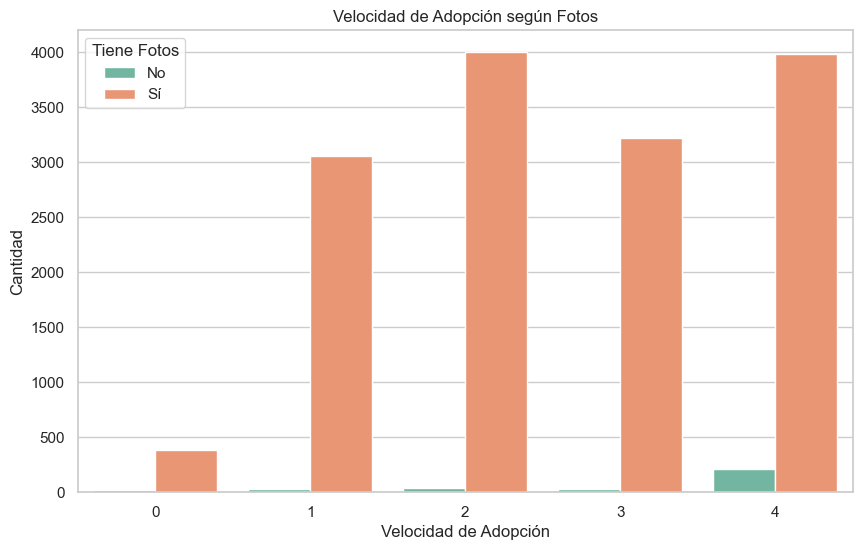

In [34]:
#Analizamos el impacto de tener fotos en la adopción:

# Crear una columna 'Has_photo' para indicar si hay o no fotos
train['Has_photo'] = train['PhotoAmt'] > 0

# Configurar las visualizaciones
plt.figure(figsize=(10, 6))
sns.countplot(x='AdoptionSpeed', data=train, hue='Has_photo', palette='Set2')
plt.title('Velocidad de Adopción según Fotos')
plt.xlabel('Velocidad de Adopción')
plt.ylabel('Cantidad')
plt.legend(title='Tiene Fotos', labels=['No', 'Sí'])
plt.show()

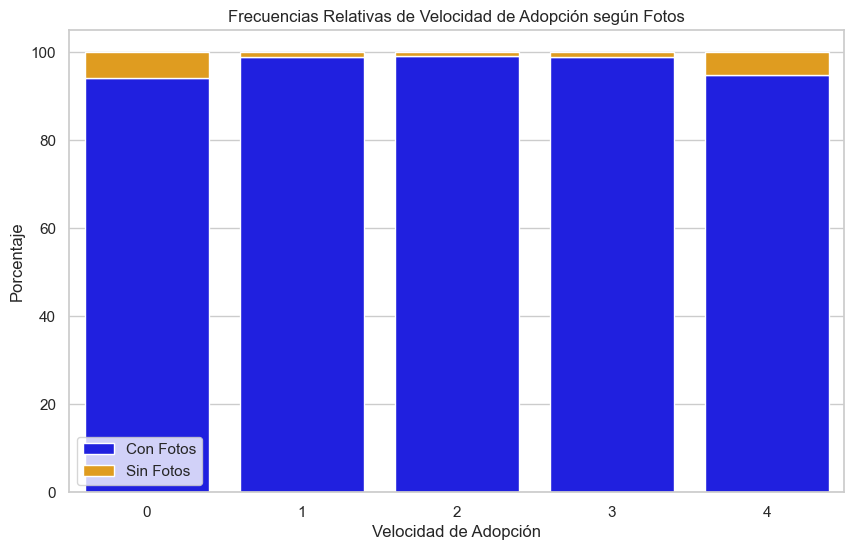

In [35]:
#Realizamos un graifco de frecuencias relativas de adopciones y fotos:

# Calcular las frecuencias relativas al 100%
freq_table = pd.crosstab(train['AdoptionSpeed'], train['Has_photo'], normalize='index') * 100

# Crear el gráfico de barras apiladas al 100%
plt.figure(figsize=(10, 6))
sns.barplot(x=freq_table.index, y=freq_table[True], color='blue', label='Con Fotos')
sns.barplot(x=freq_table.index, y=freq_table[False], color='orange', bottom=freq_table[True], label='Sin Fotos')
plt.title('Frecuencias Relativas de Velocidad de Adopción según Fotos')
plt.xlabel('Velocidad de Adopción')
plt.ylabel('Porcentaje')
plt.legend()
plt.show()


In [ ]:
#Se observa un fuerte desbalance entre los registros con foto vs los que no la tienen.
#No se observa una tendencia favorable a la adopción veloz por la existencia de fotos en el registro.

#### 3.2.14 Inspeccion de variable Video y su velocidad de adopcion

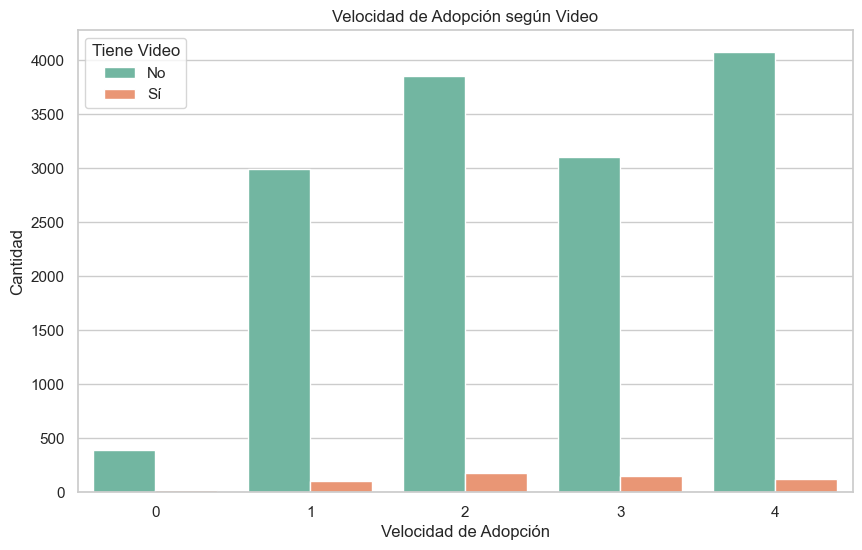

In [36]:
#analizamos el impacto de tener video en la adopción:

# Crear una columna 'Has_video' para indicar si hay o no video
train['Has_video'] = train['VideoAmt'] > 0

# Configurar las visualizaciones
plt.figure(figsize=(10, 6))
sns.countplot(x='AdoptionSpeed', data=train, hue='Has_video', palette='Set2')
plt.title('Velocidad de Adopción según Video')
plt.xlabel('Velocidad de Adopción')
plt.ylabel('Cantidad')
plt.legend(title='Tiene Video', labels=['No', 'Sí'])
plt.show()


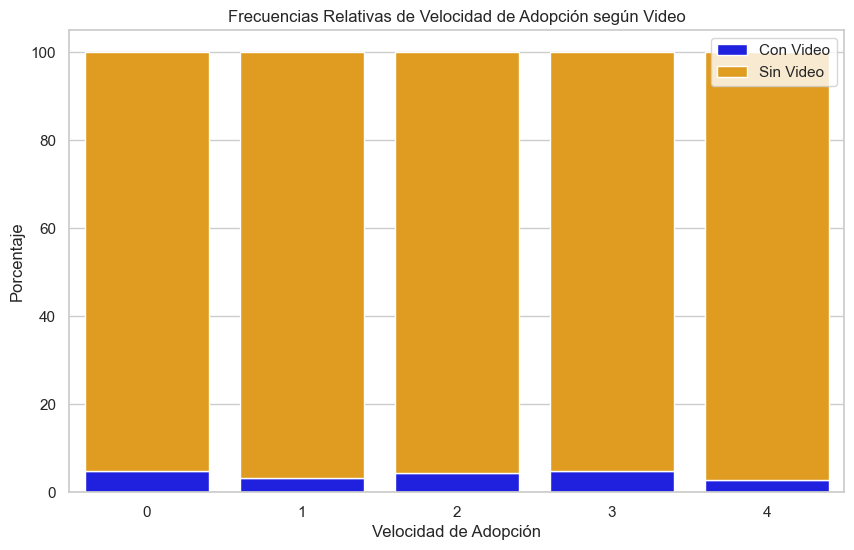

In [37]:
#Realizamos un graifco de frecuencias relativas de adopciones y videos:

# Calcular las frecuencias relativas al 100%
freq_table = pd.crosstab(train['AdoptionSpeed'], train['Has_video'], normalize='index') * 100

# Crear el gráfico de barras apiladas al 100%
plt.figure(figsize=(10, 6))
sns.barplot(x=freq_table.index, y=freq_table[True], color='blue', label='Con Video')
sns.barplot(x=freq_table.index, y=freq_table[False], color='orange', bottom=freq_table[True], label='Sin Video')
plt.title('Frecuencias Relativas de Velocidad de Adopción según Video')
plt.xlabel('Velocidad de Adopción')
plt.ylabel('Porcentaje')
plt.legend()
plt.show()


In [39]:
#Analizamos la cantidad de observaciones que tienen video y su porcentaje:

# Calcular la cantidad de observaciones con video
video_count = train['Has_video'].sum()

# Calcular el porcentaje de observaciones con video
video_percentage = video_count / train.shape[0] * 100

print("Cantidad de Observaciones con Video:", video_count)

print("Porcentaje de Observaciones con Video:", video_percentage)


Cantidad de Observaciones con Video: 574
Porcentaje de Observaciones con Video: 3.828453278196492


In [ ]:
#Se observa un fuerte desbalance entre los registros sin video vs los que lo tienen.
#No se observa una tendencia favorable a la adopción veloz por la existencia de video en el registro.

In [40]:
#Analizamos la cantidad de observaciones que tienen foto y su porcentaje:

# Calcular la cantidad de observaciones con foto
photo_count = train['Has_photo'].sum()

# Calcular el porcentaje de observaciones con foto
photo_percentage = photo_count / train.shape[0] * 100

print("Cantidad de Observaciones con Foto:", photo_count)

print("Porcentaje de Observaciones con Foto:", photo_percentage)

Cantidad de Observaciones con Foto: 14652
Porcentaje de Observaciones con Foto: 97.72560528246515


In [ ]:
#Se observa un fuerte desbalance entre los registros con foto vs los que no la tienen.
#No se observa una tendencia favorable a la adopción veloz por la existencia de fotos en el registro.

#### 3.2.15 Inspeccion de variable Quantity

C:\Users\HOME\AppData\Local\Temp\ipykernel_10220\1943171823.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Quantity', data=train, palette='viridis')


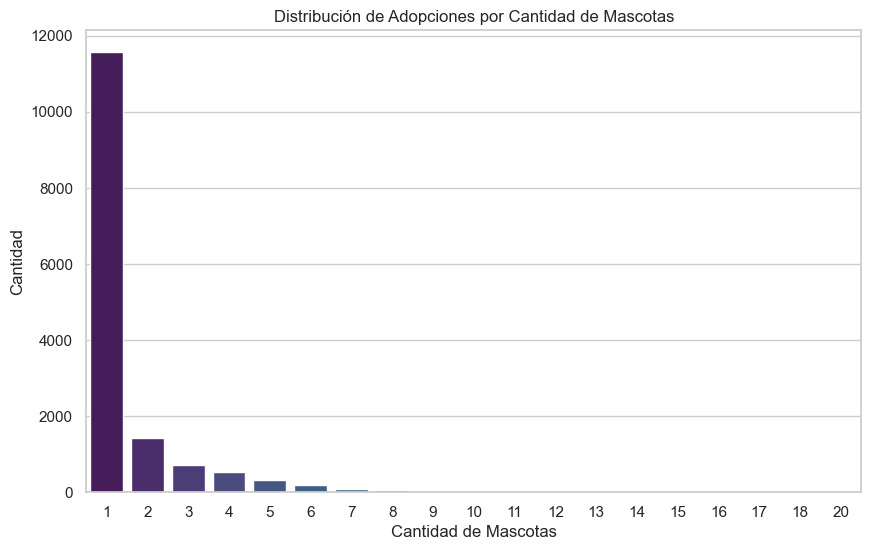

In [41]:
#Verificamos la cantidad de registros por cada categoria de la variable Quantity

# Configuración de las visualizaciones
plt.figure(figsize=(10, 6))
sns.countplot(x='Quantity', data=train, palette='viridis')
plt.title('Distribución de Adopciones por Cantidad de Mascotas')
plt.xlabel('Cantidad de Mascotas')
plt.ylabel('Cantidad')
plt.show()

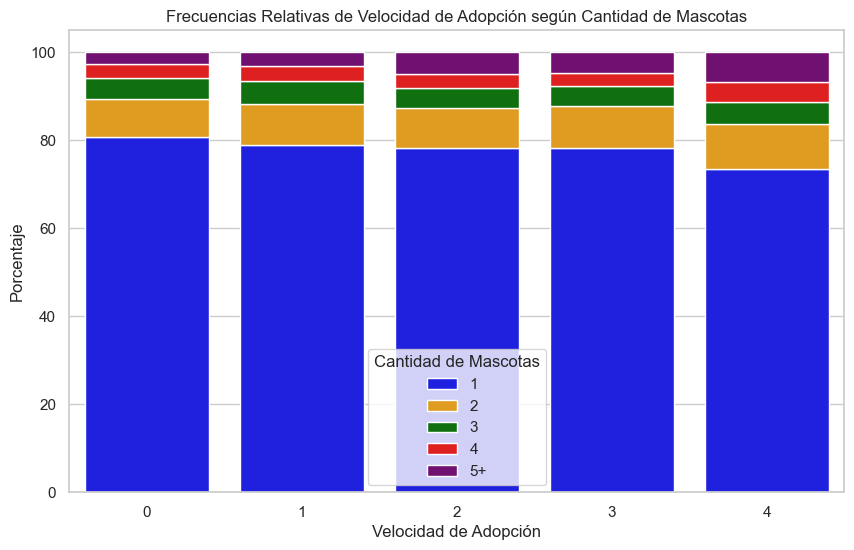

In [42]:
#Ahora indicar en porcentajes la cantidad de adopciones por cantidad de mascotas agrupando las mayores a 4 en un solo grupo

# Crear una columna 'Quantity_group' para agrupar las cantidades mayores a 4
train['Quantity_group'] = train['Quantity'].apply(lambda x: x if x <= 4 else '5+')

# Calcular las frecuencias relativas al 100%
freq_table = pd.crosstab(train['AdoptionSpeed'], train['Quantity_group'], normalize='index') * 100

# Crear el gráfico de barras apiladas al 100%
plt.figure(figsize=(10, 6))
sns.barplot(x=freq_table.index, y=freq_table[1], color='blue', label='1')
sns.barplot(x=freq_table.index, y=freq_table[2], color='orange', bottom=freq_table[1], label='2')
sns.barplot(x=freq_table.index, y=freq_table[3], color='green', bottom=freq_table[1] + freq_table[2], label='3')
sns.barplot(x=freq_table.index, y=freq_table[4], color='red', bottom=freq_table[1] + freq_table[2] + freq_table[3], label='4')
sns.barplot(x=freq_table.index, y=freq_table['5+'], color='purple', bottom=freq_table[1] + freq_table[2] + freq_table[3] + freq_table[4], label='5+')
plt.title('Frecuencias Relativas de Velocidad de Adopción según Cantidad de Mascotas')
plt.xlabel('Velocidad de Adopción')
plt.ylabel('Porcentaje')
plt.legend(title='Cantidad de Mascotas')
plt.show()

                         

In [ ]:
#La variable Quantity se evaluará en 4.3

#### 3.2.16 Inspeccion de variable Age y su velocidad de adopción

In [58]:
#Armamos una base sólo con los registros que corresponden a velocidad de adopcion 0:

# Filtrar los datos para obtener solo las mascotas adoptadas en el tiempo 0
adopted_in_0 = train[train['AdoptionSpeed'] == 0]

#mostrar las primeras 5 filas
adopted_in_0.head()


,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,Quantity_group
1,2,nan,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2,0,1
75,1,Coco,2,307,0,2,2,5,0,2,1,2,1,2,1,1,0,41336,31de822d0adce3e2dad7dcedfbee2ba8,0,Hi Coco is a rescued puppy from the streets If...,259b10a3e,1,0,1
106,2,SYLVESTER,1,266,266,3,1,7,0,2,1,1,1,2,1,2,1,41401,9b52af6d48a4521fd01d4028eb5879a3,0,Kittens found living at restaurant with siblin...,19b1f4263,3,0,2+
170,2,Sunset,2,292,252,1,2,5,0,1,1,2,2,2,1,1,0,41401,2181fc2a61447996c1e5cee02738b5c3,0,Looking for someone who really love and adore...,b9590d4de,1,0,1
259,1,Chanelle,18,20,307,2,2,7,0,2,1,1,1,1,1,1,0,41401,c00756f2bdd8fa88fc9f07a8309f7d5d,0,Chanelle found a home,1c59cecac,10,0,1


In [64]:
#Verificamos el maximo y el minimo de variable Age:

print("Edad Máxima:", adopted_in_0['Age'].max())

print("Edad Mínima:", adopted_in_0['Age'].min())


Edad Máxima: 120
Edad Mínima: 0


C:\Users\HOME\AppData\Local\Temp\ipykernel_10220\2238011962.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adopted_in_0['Age_group'] = pd.cut(adopted_in_0['Age'], bins=[0, 1, 6, 12, 24, 60, 120], labels=['0-1', '1-5', '6-11', '12-23', '24-59', '60-119'])


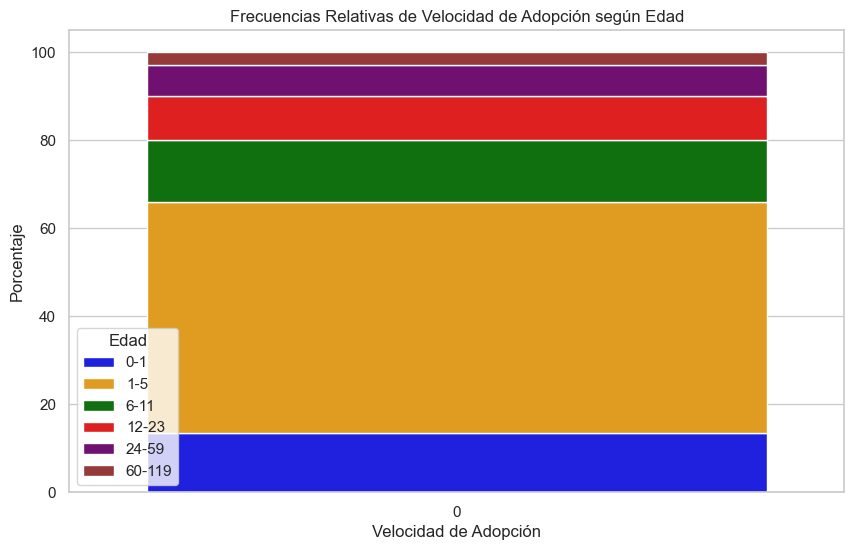

In [65]:
#verificamos los perfiles de adopción 0 y la variable Age (agrupando por rango de edades):

# Crear una columna 'Age_group' para agrupar las edades en rangos
adopted_in_0['Age_group'] = pd.cut(adopted_in_0['Age'], bins=[0, 1, 6, 12, 24, 60, 120], labels=['0-1', '1-5', '6-11', '12-23', '24-59', '60-119'])

# Calcular las frecuencias relativas al 100%
freq_table = pd.crosstab(adopted_in_0['AdoptionSpeed'], adopted_in_0['Age_group'], normalize='index') * 100

# Crear el gráfico de barras apiladas al 100%
plt.figure(figsize=(10, 6))
sns.barplot(x=freq_table.index, y=freq_table['0-1'], color='blue', label='0-1')
sns.barplot(x=freq_table.index, y=freq_table['1-5'], color='orange', bottom=freq_table['0-1'], label='1-5')
sns.barplot(x=freq_table.index, y=freq_table['6-11'], color='green', bottom=freq_table['0-1'] + freq_table['1-5'], label='6-11')
sns.barplot(x=freq_table.index, y=freq_table['12-23'], color='red', bottom=freq_table['0-1'] + freq_table['1-5'] + freq_table['6-11'], label='12-23')
sns.barplot(x=freq_table.index, y=freq_table['24-59'], color='purple', bottom=freq_table['0-1'] + freq_table['1-5'] + freq_table['6-11'] + freq_table['12-23'], label='24-59')
sns.barplot(x=freq_table.index, y=freq_table['60-119'], color='brown', bottom=freq_table['0-1'] + freq_table['1-5'] + freq_table['6-11'] + freq_table['12-23'] + freq_table['24-59'], label='60-119')
plt.title('Frecuencias Relativas de Velocidad de Adopción según Edad')
plt.xlabel('Velocidad de Adopción')
plt.ylabel('Porcentaje')
plt.legend(title='Edad')
plt.show()



C:\Users\HOME\AppData\Local\Temp\ipykernel_10220\2151117683.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='AdoptionSpeed', y='Age', data=adopted_in_0, palette='viridis')


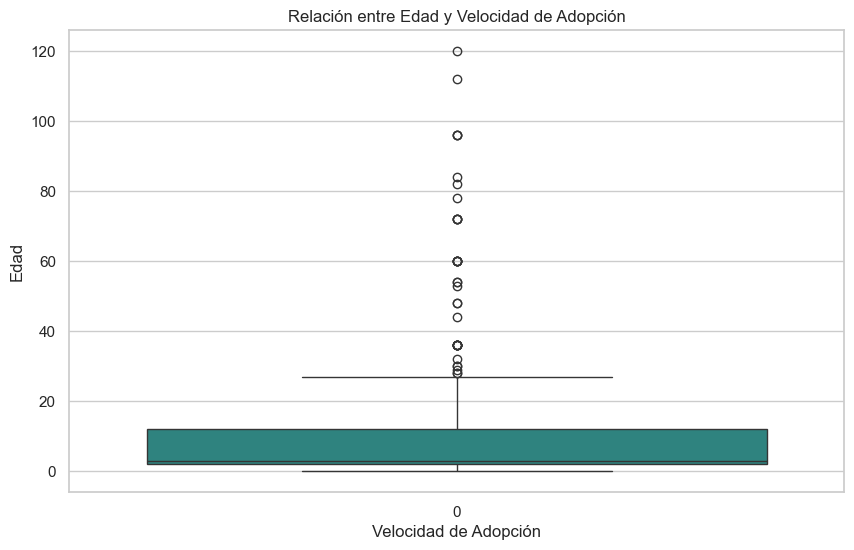

In [66]:
#Hacemos un boxplot de la variable Age para la velocidad de adopción 0:

# Configuración de las visualizaciones
plt.figure(figsize=(10, 6))
sns.boxplot(x='AdoptionSpeed', y='Age', data=adopted_in_0, palette='viridis')
plt.title('Relación entre Edad y Velocidad de Adopción')
plt.xlabel('Velocidad de Adopción')
plt.ylabel('Edad')
plt.show()


In [67]:
#mostrar cuartiles de la variable Age para la velocidad de adopción 0:

# Calcular los cuartiles de la variable 'Age' para la velocidad de adopción 0
quartiles = adopted_in_0['Age'].quantile([0.25, 0.5, 0.75])

# Imprimir los resultados
print("Cuartil 25%:", quartiles[0.25])
print("Cuartil 50%:", quartiles[0.5])
print("Cuartil 75%:", quartiles[0.75])


Cuartil 25%: 2.0
Cuartil 50%: 3.0
Cuartil 75%: 12.0


In [ ]:
#El EDA sobre la variable Age indica una  fuerte asimetría derecha, debido a la presencia de registros de cachorros en el dataset. 
#La mediana resulta en 3 meses de edad y el rango intercuartil consiste en 10 meses. 
#En el boxplot observamos la presencia de valores atípicos y outliers hasta los 120 meses de edad (10 años).
#Para velocidad de adopción 0, la población mayoritaria resulta en el segmento hasta 12 meses de edad, lo que representa un 75% de los registros asignables a cachorros.

#### 3.2.17 Inspeccionamos la variable Gender

In [69]:
#Analizamos el género de las mascotas:
# Contar los registros de la variable 'Gender'
conteo_genero = train['Gender'].value_counts()
print(conteo_genero)
 

Gender
2    7277
1    5536
3    2180
Name: count, dtype: int64


## 4. Pre Procesamiento de datos


### 4.1 Tratamiento de Nulos

In [74]:
#Abrimos el csv train2.csv del directorio actual en el cual hicimos las modificaciones
train2 = pd.read_csv('https://raw.githubusercontent.com/patsarmitagle/LABO2_Group18/main/input/train2.csv')
#cambiamamos el nombre train2 a train
train = train2

train.head()
#verificamos los nulos
train.isnull().sum()


Type                0
Name             1453
Age                 0
Breed1              0
Breed2              0
Gender              0
Color1              0
Color2              0
Color3              0
MaturitySize        0
FurLength           0
Vaccinated          0
Dewormed            0
Sterilized          0
Health              0
Quantity            0
Fee                 0
State               0
RescuerID           0
VideoAmt            0
Description        23
PetID               0
PhotoAmt            0
AdoptionSpeed       0
dtype: int64

In [46]:
# Se realizó la eliminación manual de nombres en el dataset train, debido a que se encontraron demasiados registros erróneos como para realizar un scrip integrado. 
# Entre los errores se encuentran: números, símbolos, fechas, variantes de no name, etc. En Description se siguió la misma metodología. 
# Originalmente el dataset en la variable 'Name' contenía 1265 nulls y en Description contenía 13. 
# Luego del ajuste del dataset, los nulos en 'Name' resultan en 1453 y en 'Description' resultan en 23.

### 4.2 Tratar Caracteres Especiales

In [75]:
import re

def contiene_caracteres_especiales(cadena):
    # Define un patrón para caracteres especiales
    patron = re.compile(r'[^a-zA-Z0-9\s]')
    return bool(patron.search(cadena))


In [76]:
columnas_con_caracteres_especiales = []

for columna in train.columns:
    if train[columna].apply(lambda x: contiene_caracteres_especiales(str(x))).any():
        columnas_con_caracteres_especiales.append(columna)

print("Columnas con caracteres especiales:", columnas_con_caracteres_especiales)


Columnas con caracteres especiales: ['Name', 'Description', 'PetID']


In [77]:
columnas_con_caracteres_especiales = columnas_con_caracteres_especiales[:-1]

print(columnas_con_caracteres_especiales)

['Name', 'Description']


In [78]:
def eliminar_caracteres_especiales(cadena):
    return re.sub(r'[^a-zA-Z0-9\s]', '', cadena)

for columna in columnas_con_caracteres_especiales:
    train[columna] = train[columna].apply(lambda x: eliminar_caracteres_especiales(str(x)))


In [79]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Type           14993 non-null  int64 
 1   Name           14993 non-null  object
 2   Age            14993 non-null  int64 
 3   Breed1         14993 non-null  int64 
 4   Breed2         14993 non-null  int64 
 5   Gender         14993 non-null  int64 
 6   Color1         14993 non-null  int64 
 7   Color2         14993 non-null  int64 
 8   Color3         14993 non-null  int64 
 9   MaturitySize   14993 non-null  int64 
 10  FurLength      14993 non-null  int64 
 11  Vaccinated     14993 non-null  int64 
 12  Dewormed       14993 non-null  int64 
 13  Sterilized     14993 non-null  int64 
 14  Health         14993 non-null  int64 
 15  Quantity       14993 non-null  int64 
 16  Fee            14993 non-null  int64 
 17  State          14993 non-null  int64 
 18  RescuerID      14993 non-n

### 4.3 Tratar variable Quantity

In [80]:
#Agrupamos la variable Quantity en dos categorías: 1 y 2+.

# Crear una columna 'Quantity_group' para agrupar las cantidades mayores a 1
train['Quantity_group'] = train['Quantity'].apply(lambda x: x if x <= 1 else '2+')  

# Mostrar las primeras 10 filas
train.head(10)


,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,Quantity_group
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3 month old ball of cuteness He is...,86e1089a3,1,2,1
1,2,nan,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2,0,1
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7,3,1
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,Good guard dog very alert active obedience wai...,5842f1ff5,8,2,1
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption ...,850a43f90,3,2,1
5,2,nan,3,266,0,2,5,6,0,2,1,2,2,2,1,1,0,41326,22fe332bf9c924d4718005891c63fbed,0,This is a stray kitten that came to my house H...,d24c30b4b,2,2,1
6,2,BULAT,12,264,264,1,1,0,0,2,3,2,2,3,1,1,300,41326,1e0b5a458b5b77f5af581d57ebf570b3,0,anyone within the area of ipoh or taiping who ...,1caa6fcdb,3,1,1
7,1,Siu Pak Her 6 Puppies,0,307,0,2,1,2,7,2,1,2,2,2,1,6,0,41326,1fba5f6e5480946254590d48f9c5198d,0,Siu Pak just give birth on 13610 to 6puppies I...,97aa9eeac,9,3,2+
8,2,nan,2,265,0,2,6,0,0,2,2,2,2,2,1,1,0,41326,d8af7afece71334473575c9f70daf00d,0,healthy and active feisty kitten found in neig...,c06d167ca,6,1,1
9,2,Kitty,12,265,0,2,1,7,0,2,2,3,3,3,1,1,0,41326,1f3f36e4b18e94855b3e88af0852fdc4,0,Very manja and gentle stray cat found we would...,7a0942d61,2,4,1


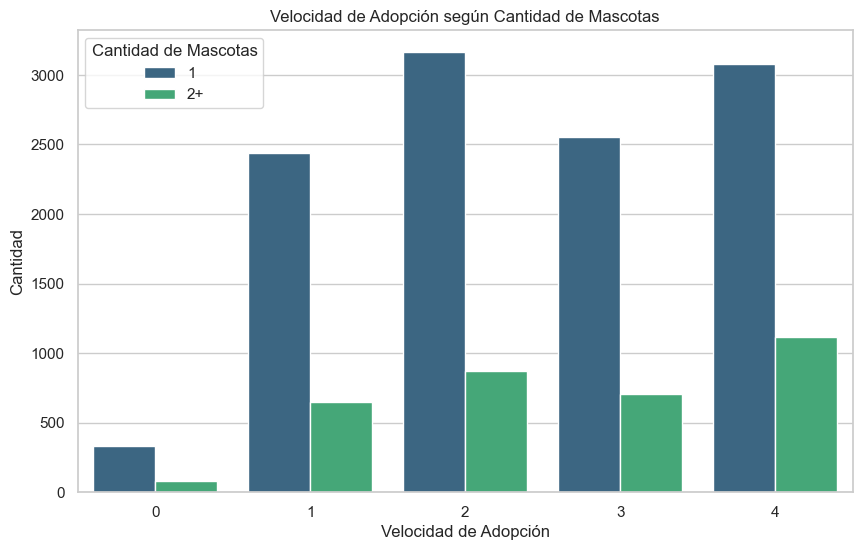

In [81]:
#Ahora comparamos la velocidad de adopción vs los dos valores que toma la variable Quantity_group:

# Configuración de las visualizaciones
plt.figure(figsize=(10, 6))
sns.countplot(x='AdoptionSpeed', data=train, hue='Quantity_group', palette='viridis')
plt.title('Velocidad de Adopción según Cantidad de Mascotas')
plt.xlabel('Velocidad de Adopción')
plt.ylabel('Cantidad')
plt.legend(title='Cantidad de Mascotas')
plt.show()


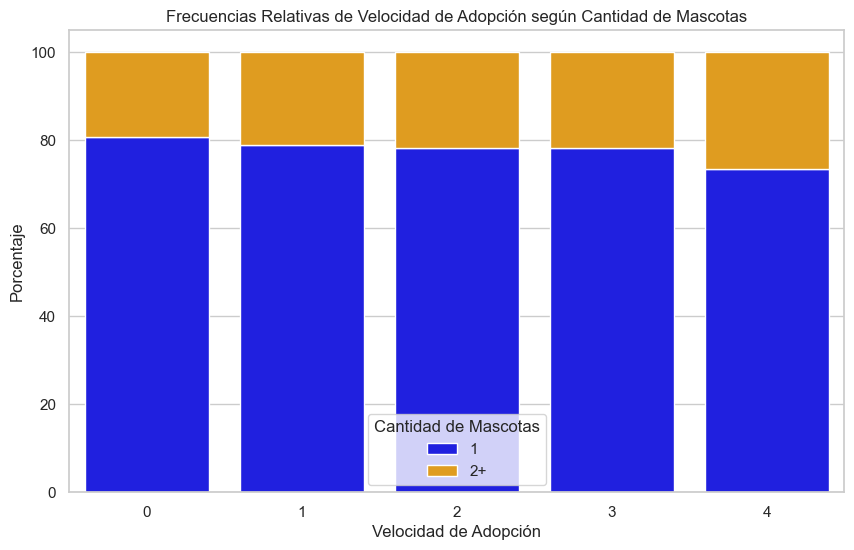

C:\Users\HOME\AppData\Local\Temp\ipykernel_10220\561251456.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='AdoptionSpeed', data=train, palette='viridis')


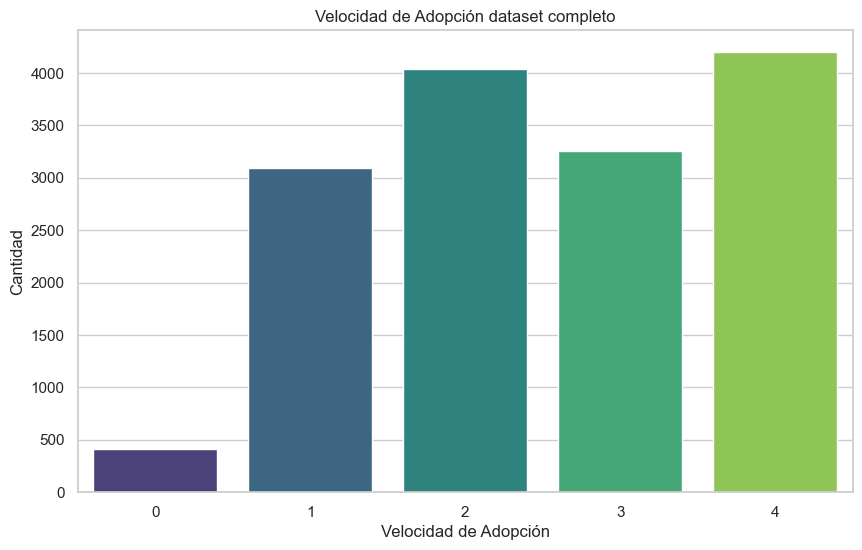

In [82]:
#Ahora creamos un indice de adopción grupal para la variable Quantity_group para cada velocidad de adopción:

# Calcular las frecuencias relativas al 100%
freq_table = pd.crosstab(train['AdoptionSpeed'], train['Quantity_group'], normalize='index') * 100

# Crear el gráfico de barras apiladas al 100%:
plt.figure(figsize=(10, 6))
sns.barplot(x=freq_table.index, y=freq_table[1], color='blue', label='1')
sns.barplot(x=freq_table.index, y=freq_table['2+'], color='orange', bottom=freq_table[1], label='2+')
plt.title('Frecuencias Relativas de Velocidad de Adopción según Cantidad de Mascotas')
plt.xlabel('Velocidad de Adopción')
plt.ylabel('Porcentaje')
plt.legend(title='Cantidad de Mascotas')
plt.show()

#Comparo con el grafico de velocidad de adopción del dataset original:

# Configuración de las visualizaciones
plt.figure(figsize=(10, 6))
sns.countplot(x='AdoptionSpeed', data=train, palette='viridis')
plt.title('Velocidad de Adopción dataset completo')
plt.xlabel('Velocidad de Adopción')
plt.ylabel('Cantidad')
plt.show()




In [ ]:
#A partir de los gráficos no parece observarse una diferencia significativa en cuanto a la velocidad de adopción entre las mascotas grupales (2+) 
# y las adoptadas individualmente (1).
#El gráfico de barras apiladas muestra casi la misma proporción de adopciones por grupo/individual para las distintas velocidades de adopción. 
#Y el perfil de adopciones individuales y grupales es msimilar (primer gráfico).

### 4.4 Unificar idioma en la variable Description (inglés)

In [ ]:
#pip install langdetect googletrans==4.0.0-rc1

from langdetect import detect
from googletrans import Translator


In [ ]:
def detectar_idioma(texto):
    try:
        return detect(texto)
    except:
        return 'unknown'  # Manejar casos donde el idioma no se pueda detectar

train['language'] = train['Description'].apply(detectar_idioma)


In [ ]:
translator = Translator()

def traducir_a_ingles(texto, idioma_origen):
    try:
        if idioma_origen != 'en':
            return translator.translate(texto, src=idioma_origen, dest='en').text
        return texto
    except:
        return texto  # Manejar errores de traducción

train['Description'] = train.apply(lambda row: traducir_a_ingles(row['Description'], row['language']), axis=1)


In [ ]:
#Se unifica el idioma para trabajar con las descripciones en inglés para luego agregar nuevas caracteristicas en FE. 

## 5. Feature Engeneering


In [ ]:
#5.3 crear variable de salud integral-Fer, caso 1 de salud integral aumenta con la vel de adopción, cruzar con edad por cachorros.
#5.4 crear variable razas puras-Patri
#5.5 variable edad: cachorro , joven, adulto, senior-Marcos
#anulado-sentimientos a partir de descripción-Patri

### 5.1 Creación de variable colores puros

In [5]:
#Cuento la cantidad de Color1==0:
train['Color1'].value_counts()
print(train['Color1'].value_counts())

#Suma total de registros de Color1:
train['Color1'].count()
print(train['Color1'].count())

#Cuento la cantidad de Color2==0:
train['Color2'].value_counts()
print(train['Color2'].value_counts())

#Suma total de registros de 2:
train['Color2'].count()
print(train['Color2'].count())

#Cuento la cantidad de Color3==0:
train['Color3'].value_counts()
print(train['Color3'].value_counts())

#Suma total de registros de Color3:
train['Color3'].count()
print(train['Color3'].count())

# Creamos una nueva variable 'Pure_color' que indica si el color de la mascota es puro o no:
train['Pure_color'] = (train['Color1'] == 1) & (train['Color2'] == 0) & (train['Color3'] == 0)

# Mostrar las primeras 5 filas
train.head()

#Contar cuantos registros hay de cada factor de la variable Pure_color y su porcentaje:
#Calcular la cantidad de observaciones con colores puros
pure_color_count = train['Pure_color'].sum()

#Calcular el porcentaje de observaciones con colores puros:
pure_color_percentage = pure_color_count / train.shape[0] * 100

print("Cantidad de Observaciones con Colores Puros:", pure_color_count)

print("Porcentaje de Observaciones con Colores Puros:", pure_color_percentage)


Color1
1    7427
2    3750
3     947
5     884
6     684
7     667
4     634
Name: count, dtype: int64
14993
Color2
0    4471
7    3438
2    3313
5    1128
6    1063
4     870
3     710
Name: count, dtype: int64
14993
Color3
0    10604
7     3221
5      417
6      378
4      198
3      175
Name: count, dtype: int64
14993
Cantidad de Observaciones con Colores Puros: 1002
Porcentaje de Observaciones con Colores Puros: 6.683118788768091


In [6]:
train.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,Pure_color
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,False
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,False
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,False
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,False
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,True


In [ ]:
#Colores puros es una variable muy desbalanceada, con aprox. el 7% de los registros para color puro vs el 93% de registros para colores no puros -mezclas-.

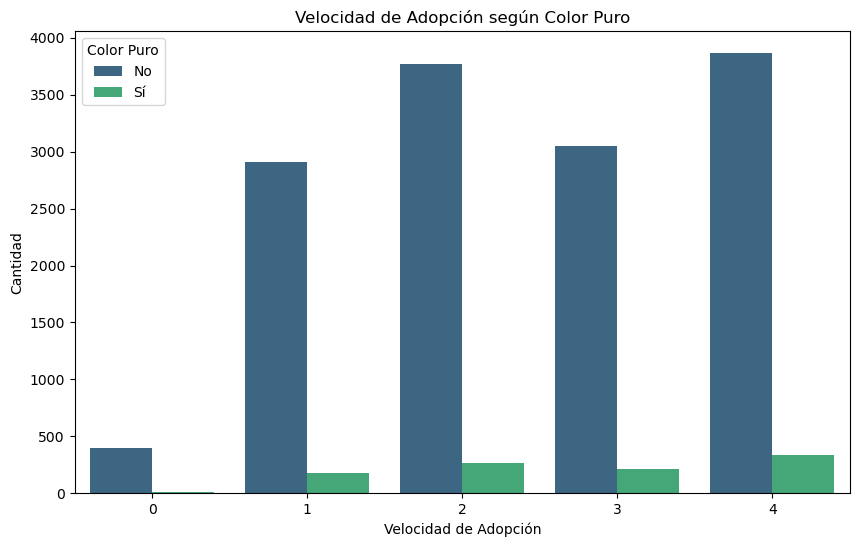

In [7]:
#Ahora graficamos la velocidad de adopción según si el color de la mascota es puro o no:

# Configuración de las visualizaciones
plt.figure(figsize=(10, 6))
sns.countplot(x='AdoptionSpeed', data=train, hue='Pure_color', palette='viridis')
plt.title('Velocidad de Adopción según Color Puro')
plt.xlabel('Velocidad de Adopción')
plt.ylabel('Cantidad')
plt.legend(title='Color Puro', labels=['No', 'Sí'])
plt.show()


In [ ]:
#Color puro "No" -mezcla- sigue el mismo perfil de velocidades de adopción del dataset completo.

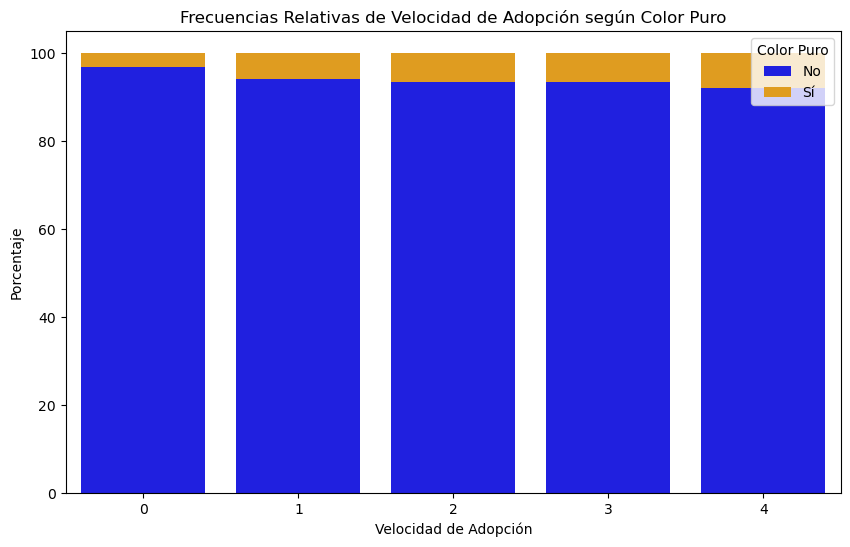

In [8]:
#Graficamos ahora en barras apiladas la velocidad de adopción según si el color de la mascota es puro o no:

# Calcular las frecuencias relativas al 100%
freq_table = pd.crosstab(train['AdoptionSpeed'], train['Pure_color'], normalize='index') * 100

# Crear el gráfico de barras apiladas al 100%
plt.figure(figsize=(10, 6))
sns.barplot(x=freq_table.index, y=freq_table[False], color='blue', label='No')
sns.barplot(x=freq_table.index, y=freq_table[True], color='orange', bottom=freq_table[False], label='Sí')
plt.title('Frecuencias Relativas de Velocidad de Adopción según Color Puro')
plt.xlabel('Velocidad de Adopción')
plt.ylabel('Porcentaje')
plt.legend(title='Color Puro', loc='upper right')
plt.show()


In [ ]:
#No parece observarse a partir del grafico de barras apiladas una tendencia favorable a la adopción mas veloz por el color puro.
#Por el contrario, la tendencia parece mostrar que el color puro es ligermaente mas preponderante en velocidades de adopción alta.

### 5.2 Combinación de variables género y esterilización

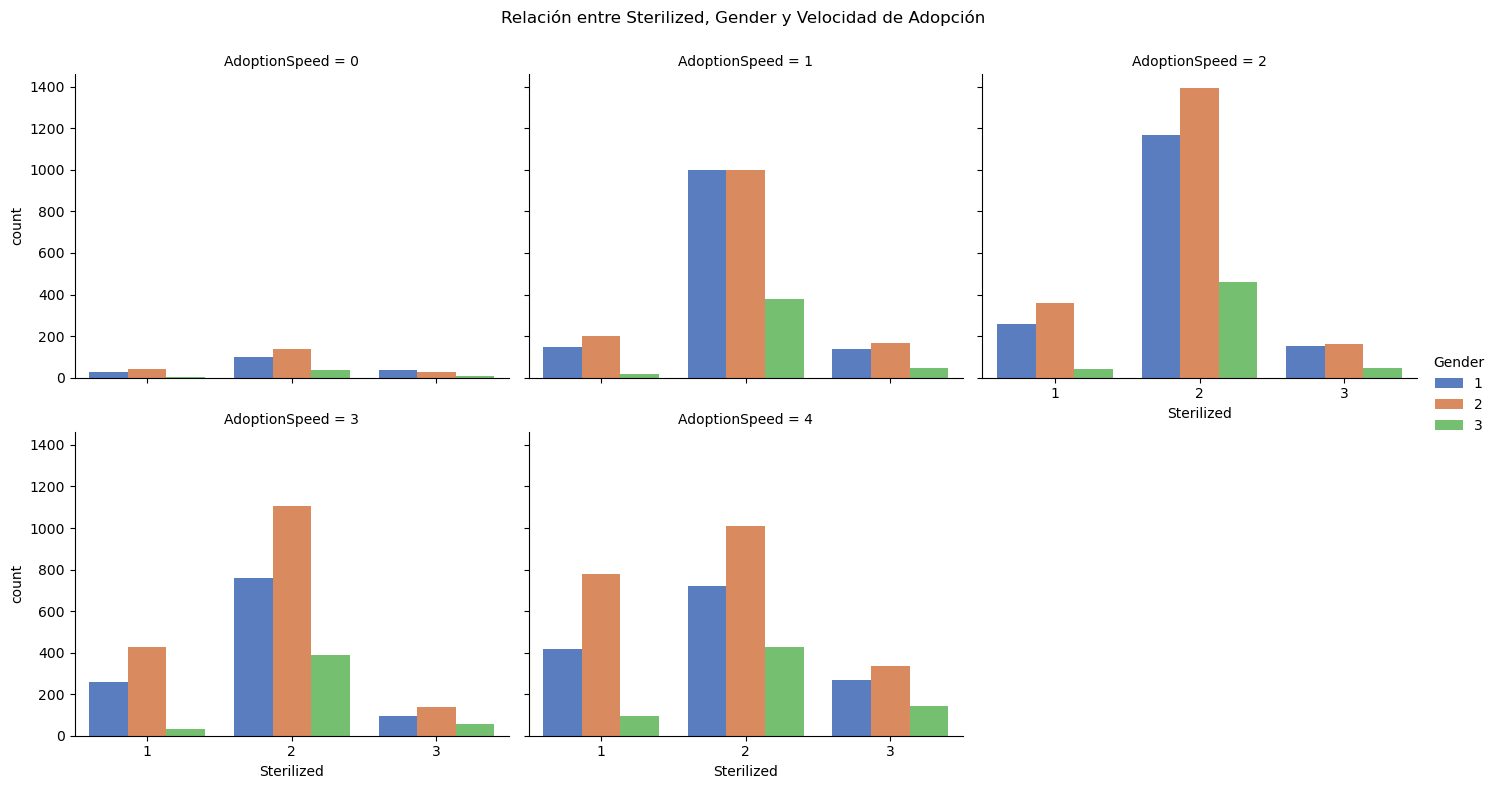

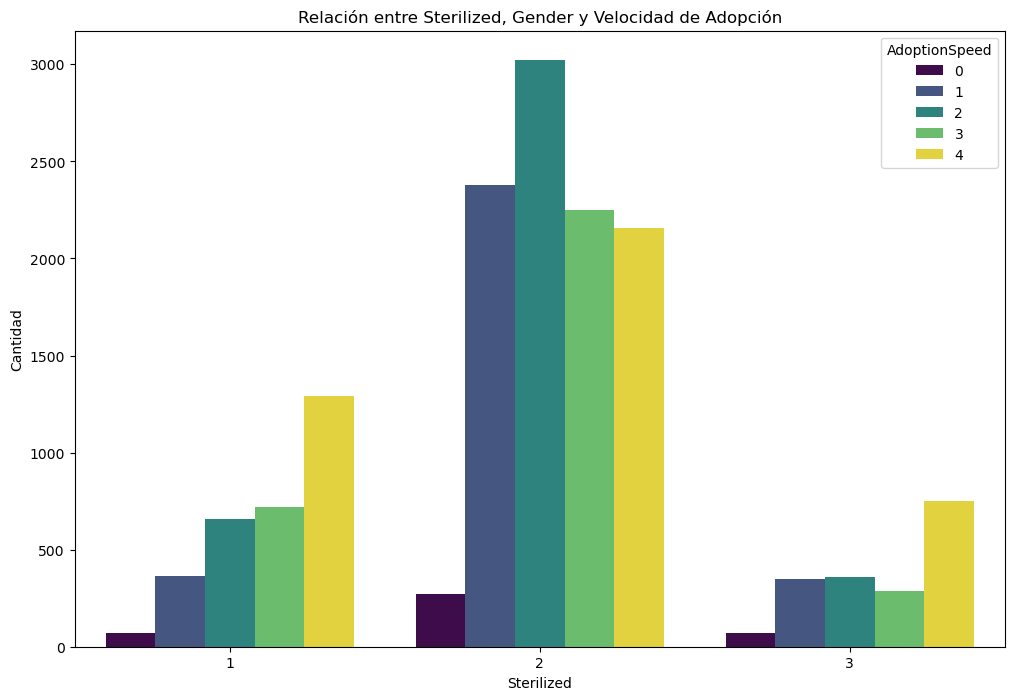

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear el gráfico de barras agrupadas con "AdoptionSpeed" como variable de color
sns.catplot(data=train2, x='Sterilized', hue='Gender', col='AdoptionSpeed', kind='count', palette='muted', col_wrap=3, height=4, aspect=1.2)

# Ajustar títulos y etiquetas
plt.subplots_adjust(top=0.9)
plt.suptitle('Relación entre Sterilized, Gender y Velocidad de Adopción')

# Mostrar el gráfico
plt.show()


# Crear el gráfico de barras agrupadas con "AdoptionSpeed" como variable de color
plt.figure(figsize=(12, 8))
sns.countplot(data=train2, x='Sterilized', hue='AdoptionSpeed', palette='viridis', dodge=True)

# Agregar título y etiquetas
plt.title('Relación entre Sterilized, Gender y Velocidad de Adopción')
plt.xlabel('Sterilized')
plt.ylabel('Cantidad')
plt.legend(title='AdoptionSpeed')

# Mostrar el gráfico
plt.show()

In [ ]:
#No se observa una relación directa entre la velocidad de adopción, el género y la esterilización de las mascotas.

### 5.3 Creación de variable de salud integral

In [10]:
#Creamos una variable 'Health_Int' que indica si la mascota tiene un estado de salud integral bueno o no.
#La variable toma el valor 1 si la mascota tiene Health=1, Dewormed=1, Sterilized=1, Vaccinated=1, y 0 en caso contrario.

# Crear una columna 'Health_Int' para indicar si la mascota tiene un estado de salud integral
train['Health_Int'] = (train['Health'] == 1) & (train['Dewormed'] == 1) & (train['Sterilized'] == 1) & (train['Vaccinated'] == 1)

#Toma valor cero si no cumple con las condiciones:
train['Health_Int'] = train['Health_Int'].apply(lambda x: 1 if x else 0)

# Mostrar las primeras 5 filas
train.head()
print(train.head())

#Contamos cuantos registros de cada factor de la variable Health_Int y su porcentaje:
# Calcular la cantidad de observaciones con estado de salud integral
health_int_count = train['Health_Int'].sum()
print("Cantidad de Observaciones con Estado de Salud Integral=1:", health_int_count)

# Calcular el porcentaje de observaciones con estado de salud integral
health_int_percentage = health_int_count / train.shape[0] * 100
print("Porcentaje de Observaciones con Estado de Salud Integral=1:", health_int_percentage)

   Type         Name  Age  Breed1  Breed2  Gender  Color1  Color2  Color3  \
0     2       Nibble    3     299       0       1       1       7       0   
1     2  No Name Yet    1     265       0       1       1       2       0   
2     1       Brisco    1     307       0       1       2       7       0   
3     1         Miko    4     307       0       2       1       2       0   
4     1       Hunter    1     307       0       1       1       0       0   

   MaturitySize  FurLength  Vaccinated  Dewormed  Sterilized  Health  \
0             1          1           2         2           2       1   
1             2          2           3         3           3       1   
2             2          2           1         1           2       1   
3             2          1           1         1           2       1   
4             2          1           2         2           2       1   

   Quantity  Fee  State                         RescuerID  VideoAmt  \
0         1  100  41326  8480853f

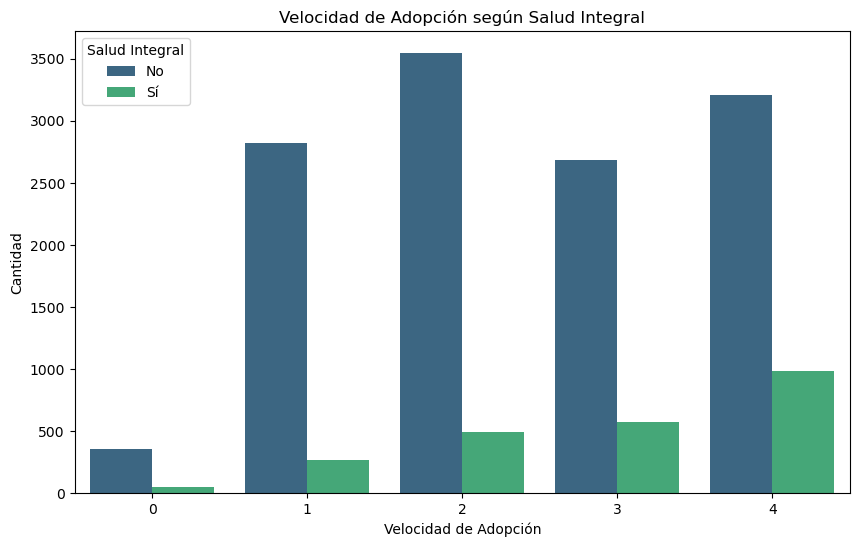

In [11]:
#Ahora graficamos Health_Int vs AdoptionSpeed:

# Configuración de las visualizaciones
plt.figure(figsize=(10, 6))
sns.countplot(x='AdoptionSpeed', data=train, hue='Health_Int', palette='viridis')
plt.title('Velocidad de Adopción según Salud Integral')
plt.xlabel('Velocidad de Adopción')
plt.ylabel('Cantidad')
plt.legend(title='Salud Integral', labels=['No', 'Sí'])
plt.show()


In [ ]:
#El factor Health_Int=1 (o sí), representa el 15% del dataset y muestra un perfil de cantidades crecientes junto con la velocidad de adopción. 
# Por otro lado, el factor 0 (o no), representa el 85% de los registros y toma el perfil general del dataset train. 
#La velocidad de adopción es una variable temporal, con lo que resulta coherente que a mayor demora en la adopción (vel=>4), se hayan cumplido con los procedimientos preventivos de salud como vacunaciones, desparasitación, esterilización, etc.
#Sería interesante estudiar este efecto de salud integral sólo aplicado a los cachorrros (que por su corta edad pertenecen al grupo: sin vacunar, sin esterilizar y posiblemente sin desparasitar, o sea Helath_Int=0).

### 5.4 Agregado de variable raza Pura 

In [12]:
# Definir las condiciones
#Se considera puro en el caso de ser perro, si la raza 1 es distitna de 307 (mixed breed) y la raza 2 es igual a 0 o a la raza 1 
#para el caso de los perros se condiera puro si la raza 1 es distinta de 0 y la raza 2 es 0 o igual a la 1 
conditions = [
    ((train['Type'] == 1) & (train['Breed1'] != 0) & (train['Breed1'] != 307) & ((train['Breed2'] == 0) | (train['Breed2'] == train['Breed1']))),
    ((train['Type'] == 2) & (train['Breed1'] != 0) & ((train['Breed2'] == 0) | (train['Breed2'] == train['Breed1'])))
]

# Asignar 1 si se cumple alguna de las condiciones, de lo contrario asignar 0
train['Es_Puro'] = 0
train.loc[conditions[0] | conditions[1], 'Es_Puro'] = 1

# Mostrar las primeras filas del DataFrame para verificar
print(train.head(15))

    Type                     Name  Age  Breed1  Breed2  Gender  Color1  \
0      2                   Nibble    3     299       0       1       1   
1      2              No Name Yet    1     265       0       1       1   
2      1                   Brisco    1     307       0       1       2   
3      1                     Miko    4     307       0       2       1   
4      1                   Hunter    1     307       0       1       1   
5      2                      NaN    3     266       0       2       5   
6      2                    BULAT   12     264     264       1       1   
7      1  Siu Pak & Her 6 Puppies    0     307       0       2       1   
8      2                      NaN    2     265       0       2       6   
9      2                    Kitty   12     265       0       2       1   
10     1                     Bear    2     307       0       1       1   
11     2                     Kali    3     264       0       2       1   
12     1                   Peanut    2

### 5.5 Creación de variable Edad por rangos

In [14]:
#Segmentamos la variable edad de acuerdo a: cachorro (0), adulto (1), senior(2)

import matplotlib.pyplot as plt
import seaborn as sns

#seleccionamos la variable Age para velociadad 0
# Filtrar los datos para obtener solo las mascotas adoptadas en el tiempo 0
adopted_in_0 = train[train['AdoptionSpeed'] == 0]
#contamos los registros en adopted_in_0
print(adopted_in_0.shape)


# Crear una columna 'Age_group' para agrupar las edades en rangos
train['Age_group'] = pd.cut(train['Age'], bins=[0, 12, 84, 360], labels=[0, 1, 2]) # los puppies tiene hasta 12 meses, los adultos hasta 84 meses y los senior 85+ meses

# Mostrar las primeras 5 filas
train.head()


(410, 28)


,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,Pure_color,Health_Int,Es_Puro,Age_group
0,2,Nibble,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,False,0,1,0
1,2,No Name Yet,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,False,0,1,0
2,1,Brisco,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,False,0,0,0
3,1,Miko,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,False,0,0,0
4,1,Hunter,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,True,0,0,0


### 5.6 FE a partir de descripción - analizando la longitud en palabras y caracteres 

C:\Users\marco\AppData\Local\Temp\ipykernel_27352\1841558529.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='desc_language', data=train, ax=axs[1, 0], palette='viridis')


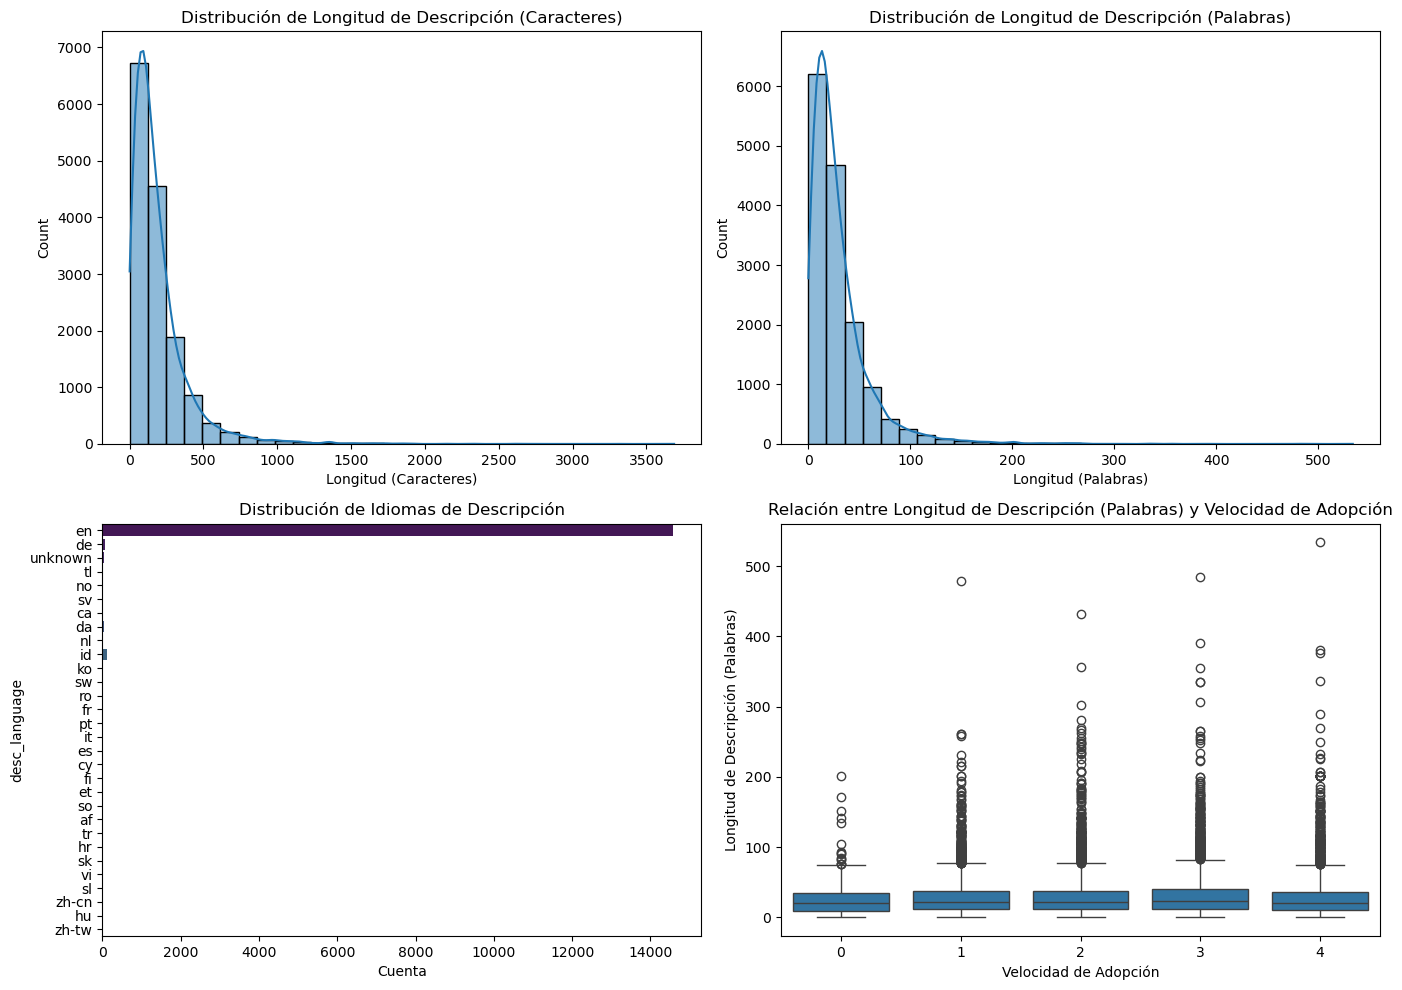

       PetID  AdoptionSpeed  desc_length_char  desc_length_word desc_language
0  86e1089a3              2               209                31            en
1  6296e909a              0                71                10            en
2  3422e4906              3               249                34            en
3  5842f1ff5              2                98                15            en
4  850a43f90              2               186                30            en


<bound method NDFrame.head of        Type            Name  Age  Breed1  Breed2  Gender  Color1  Color2  \
0         2          Nibble    3     299       0       1       1       7   
1         2             NaN    1     265       0       1       1       2   
2         1          Brisco    1     307       0       1       2       7   
3         1            Miko    4     307       0       2       1       2   
4         1          Hunter    1     307       0       1       1       0   
...     ...             ...  ...     ...     ...     ...     ...     ...   
14988     2             NaN    2     266       0       3       1       0   
14989     2  Serato & Eddie   60     265     264       3       1       4   
14990     2         Monkies    2     265     266       3       5       6   
14991     2         Ms Daym    9     266       0       2       4       7   
14992     1            Fili    1     307     307       1       2       0   

       Color3  MaturitySize  FurLength  Vaccinated  Dewor

In [64]:
#Agregar Librería para detectar idioma
from langdetect import detect
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS as stopwords



# Función para limpiar y preprocesar el texto
def clean_text(text):
    text = re.sub(r'\d+', '', text)  # Eliminar números
    text = re.sub(r'\W+', ' ', text)  # Eliminar caracteres especiales
    text = text.lower()  # Convertir a minúsculas
    text = ' '.join([word for word in text.split() if word not in stopwords])  # Eliminar stopwords
    return text

# Aplicar la función de limpieza
train['cleaned_description'] = train['Description'].fillna('').apply(clean_text)

# Extraer longitud de la descripción
train['desc_length_char'] = train['cleaned_description'].apply(len)
train['desc_length_word'] = train['cleaned_description'].apply(lambda x: len(x.split()))

# Detectar idioma de la descripción
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

train['desc_language'] = train['Description'].fillna('').apply(detect_language)

# Visualizar la distribución de las nuevas características
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Longitud de la descripción (caracteres)
sns.histplot(train['desc_length_char'], bins=30, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Distribución de Longitud de Descripción (Caracteres)')
axs[0, 0].set_xlabel('Longitud (Caracteres)')

# Longitud de la descripción (palabras)
sns.histplot(train['desc_length_word'], bins=30, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Distribución de Longitud de Descripción (Palabras)')
axs[0, 1].set_xlabel('Longitud (Palabras)')

# Distribución del idioma de la descripción
sns.countplot(y='desc_language', data=train, ax=axs[1, 0], palette='viridis')
axs[1, 0].set_title('Distribución de Idiomas de Descripción')
axs[1, 0].set_xlabel('Cuenta')

# Relación entre longitud de la descripción y velocidad de adopción
sns.boxplot(x='AdoptionSpeed', y='desc_length_word', data=train, ax=axs[1, 1])
axs[1, 1].set_title('Relación entre Longitud de Descripción (Palabras) y Velocidad de Adopción')
axs[1, 1].set_xlabel('Velocidad de Adopción')
axs[1, 1].set_ylabel('Longitud de Descripción (Palabras)')

plt.tight_layout()
plt.show()

# Mostrar algunas filas del dataframe con las nuevas columnas
print(train[['PetID', 'AdoptionSpeed', 'desc_length_char', 'desc_length_word', 'desc_language']].head())
train.head

Analisis de Sentimientos a partir de la descripción

In [72]:
import os
import json
import pandas as pd
import numpy as np

def extract_sentiment_features(json_data):
    """
    Extract average sentiment score and magnitude from JSON data.
    """
    scores = [sentence['sentiment']['score'] for sentence in json_data['sentences']]
    magnitudes = [sentence['sentiment']['magnitude'] for sentence in json_data['sentences']]
    return np.mean(scores), np.mean(magnitudes)

def analyze_sentiments(train, path_to_sentiment_files_train):
    """
    Insert sentiment features into the dataframe.
    """
    scores = []
    for file in os.listdir(path_to_sentiment_files_train):
        if file.endswith('.json'):
            file_path = os.path.join(path_to_sentiment_files_train, file)
            with open(file_path, 'r') as f:
                try:
                    sentiment = json.load(f)
                    pet_id = file.split('.')[0]
                    avg_score, avg_magnitude = extract_sentiment_features(sentiment)
                    scores.append({
                        "PetID": pet_id,
                        "sentiment_score": avg_score,
                        "sentiment_magnitude": avg_magnitude
                    })
                except Exception as e:
                    print(f"Error processing {file}: {e}")
    
    sentiment_train = pd.DataFrame(scores)
    
    # Verificar las columnas antes de la fusión
    print("Columnas en 'train' antes de la fusión:", train.columns)
    print("Columnas en 'sentiment_train' antes de la fusión:", sentiment_train.columns)
    
    # Asegurarse de que los nombres de las columnas no tienen espacios en blanco
    train.columns = train.columns.str.strip()
    sentiment_train.columns = sentiment_train.columns.str.strip()
    
    # Verificar si 'PetID' está presente en ambos DataFrames
    if 'PetID' not in train.columns:
        raise KeyError("'PetID' no está presente en el DataFrame 'train'")
    
    if 'PetID' not in sentiment_train.columns:
        raise KeyError("'PetID' no está presente en el DataFrame 'sentiment_train'")
    
    # Merge sentiment features
    train = pd.merge(train, sentiment_train, on='PetID', how='left')
    return train


# Verificar si 'PetID' está presente en 'train'
if 'PetID' not in train.columns:
    raise KeyError("'PetID' no está presente en el archivo CSV 'train'")

# Especificar la ruta a los archivos de sentimiento
path_to_sentiment_files_train = '../../input/petfinder-adoption-prediction/train_sentiment'

# Analizar los sentimientos y actualizar el DataFrame
train = analyze_sentiments(train, path_to_sentiment_files_train)

# Ver la cabecera del DataFrame
print(train.head())


Columnas en 'train' antes de la fusión: Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'Quantity_group', 'language', 'Pure_color', 'Es_Puro', 'Age_group',
       'cleaned_description', 'desc_length_char', 'desc_length_word',
       'desc_language'],
      dtype='object')
Columnas en 'sentiment_train' antes de la fusión: RangeIndex(start=0, stop=0, step=1)


AttributeError: Can only use .str accessor with string values!

In [65]:
import os
import json
import pandas as pd
import numpy as np

def extract_sentiment_features(json_data):
    """
    Extract average sentiment score and magnitude from JSON data.
    """
    scores = [sentence['sentiment']['score'] for sentence in json_data['sentences']]
    magnitudes = [sentence['sentiment']['magnitude'] for sentence in json_data['sentences']]
    return np.mean(scores), np.mean(magnitudes)

def analyze_sentiments(train, path_to_sentiment_files_train):
    """
    Insert sentiment features into the dataframe.
    """
    scores = []
    for file in os.listdir(path_to_sentiment_files_train):
        if file.endswith('.json'):
            file_path = os.path.join(path_to_sentiment_files_train, file)
            with open(file_path, 'r') as f:
                try:
                    sentiment = json.load(f)
                    pet_id = file.split('.')[0]
                    avg_score, avg_magnitude = extract_sentiment_features(sentiment)
                    scores.append({
                        "PetID": pet_id,
                        "sentiment_score": avg_score,
                        "sentiment_magnitude": avg_magnitude
                    })
                except Exception as e:
                    print(f"Error processing {file}: {e}")
    
    sentiment_train = pd.DataFrame(scores)
    
    # Merge sentiment features
    train = pd.merge(train, sentiment_train, on='PetID', how='left')
    return train


# Specify the path to your sentiment files
path_to_sentiment_files_train = '../../input/petfinder-adoption-prediction/train_sentiment'

# Analyze sentiments and update the DataFrame
train = analyze_sentiments(train, path_to_sentiment_files_train)

# View the head of the DataFrame
print(train.head())



KeyError: 'PetID'

In [ ]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Type                 14993 non-null  int64   
 1   Name                 14993 non-null  object  
 2   Age                  14993 non-null  int64   
 3   Breed1               14993 non-null  int64   
 4   Breed2               14993 non-null  int64   
 5   Gender               14993 non-null  int64   
 6   Color1               14993 non-null  int64   
 7   Color2               14993 non-null  int64   
 8   Color3               14993 non-null  int64   
 9   MaturitySize         14993 non-null  int64   
 10  FurLength            14993 non-null  int64   
 11  Vaccinated           14993 non-null  int64   
 12  Dewormed             14993 non-null  int64   
 13  Sterilized           14993 non-null  int64   
 14  Health               14993 non-null  int64   
 15  Quantity           

In [ ]:
frecuencia_valores = train['PhotoAmt'].value_counts()
print("Frecuencia de valores en la columna:")
print(frecuencia_valores)

Frecuencia de valores en la columna:
PhotoAmt
10     3075
20     2518
30     2511
50     2147
40     1881
60      621
70      432
00      341
80      314
90      231
100     190
110     184
120      97
130      86
140      78
150      50
160      39
170      27
200      25
190      20
300      19
180      18
210      16
240      15
230      12
260      10
220       9
250       8
280       7
270       6
290       6
Name: count, dtype: int64


## 6. Separa la base de Test y Train


In [ ]:
# Definir las características originales
features_originales = [
    'Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3',
    'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health',
    'Quantity', 'Fee', 'State', 'VideoAmt', 'PhotoAmt'
]

# Definir las características después del Feature Engineering (FE)
features_FE = features_originales + [
    'Pure_color', 'Health_Int', 'Es_Puro', 'Age_group',
    'desc_length_char', 'desc_length_word', 'sentiment_score',
    'sentiment_magnitude'
]

# Definir la etiqueta (label)
label = 'AdoptionSpeed'



In [ ]:
traindf, testdf = train_test_split(train,
                               test_size = TEST_SIZE,
                               random_state = SEED,
                               stratify = train.AdoptionSpeed)



In [ ]:
X_train = traindf[features_FE]
y_train = traindf[label]

X_test = testdf[features_FE]
y_test = testdf[label]

In [ ]:
print(X_train.info())

<class 'pandas.core.frame.DataFrame'>
Index: 11994 entries, 10257 to 14164
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Type                 11994 non-null  int64   
 1   Age                  11994 non-null  int64   
 2   Breed1               11994 non-null  int64   
 3   Breed2               11994 non-null  int64   
 4   Gender               11994 non-null  int64   
 5   Color1               11994 non-null  int64   
 6   Color2               11994 non-null  int64   
 7   Color3               11994 non-null  int64   
 8   MaturitySize         11994 non-null  int64   
 9   FurLength            11994 non-null  int64   
 10  Vaccinated           11994 non-null  int64   
 11  Dewormed             11994 non-null  int64   
 12  Sterilized           11994 non-null  int64   
 13  Health               11994 non-null  int64   
 14  Quantity             11994 non-null  int64   
 15  Fee                 

In [ ]:
print(y_train.info())

<class 'pandas.core.series.Series'>
Index: 11994 entries, 10257 to 14164
Series name: AdoptionSpeed
Non-Null Count  Dtype
--------------  -----
11994 non-null  int64
dtypes: int64(1)
memory usage: 187.4 KB
None


### 7. Para la parte de Train, armar un esquema de Cross Validation


In [ ]:
#Genero una metrica para que lightGBM haga la evaluación y pueda hacer early_stopping en el cross validation
def lgb_custom_metric_kappa(dy_pred, dy_true):
    metric_name = 'kappa'
    value = cohen_kappa_score(dy_true.get_label(),dy_pred.argmax(axis=1),weights = 'quadratic')
    is_higher_better = True
    return(metric_name, value, is_higher_better)

#Funcion objetivo a optimizar. En este caso vamos a hacer 5fold cv sobre el conjunto de train. 
# El score de CV es el objetivo a optimizar. Ademas vamos a usar los 5 modelos del CV para estimar el conjunto de test,
# registraremos en optuna las predicciones, matriz de confusion y el score en test.
# CV Score -> Se usa para determinar el rendimiento de los hiperparametros con precision 
# Test Score -> Nos permite testear que esta todo OK, no use (ni debo usar) esos datos para nada en el entrenamiento 
# o la optimizacion de hiperparametros

def cv_es_lgb_objective(trial):

    #PArametros para LightGBM
    lgb_params = {      
                        #PArametros fijos
                        'objective': 'multiclass',
                        'verbosity':-1,
                        'num_class': len(y_train.unique()),
                        #Hiperparametros a optimizar utilizando suggest_float o suggest_int segun el tipo de dato
                        #Se indica el nombre del parametro, valor minimo, valor maximo 
                        #en elgunos casos el parametro log=True para parametros que requieren buscar en esa escala
                        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
                        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
                        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
                        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
                        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
                        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                        } 

    #Voy a generar estimaciones de los 5 modelos del CV sobre los datos test y los acumulo en la matriz scores_ensemble
    scores_ensemble = np.zeros((len(y_test),len(y_train.unique())))

    #Score del 5 fold CV inicializado en 0
    score_folds = 0

    #Numero de splits del CV
    n_splits = 5

    #Objeto para hacer el split estratificado de CV
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (if_index, oof_index) in enumerate(skf.split(X_train, y_train)):
        
        #Dataset in fold (donde entreno) 
        lgb_if_dataset = lgb.Dataset(data=X_train.iloc[if_index],
                                        label=y_train.iloc[if_index],
                                        free_raw_data=False)
        
        #Dataset Out of fold (donde mido la performance del CV)
        lgb_oof_dataset = lgb.Dataset(data=X_train.iloc[oof_index],
                                        label=y_train.iloc[oof_index],
                                        free_raw_data=False)

        #Entreno el modelo
        lgb_model = lgb.train(lgb_params,
                                lgb_if_dataset,
                                valid_sets=lgb_oof_dataset,
                                callbacks=[lgb.early_stopping(10, verbose=False)],
                                feval = lgb_custom_metric_kappa
                                )
        
        #Acumulo los scores (probabilidades) de cada clase para cada uno de los modelos que determino en los folds
        #Se predice el 20% de los datos que separe para tes y no uso para entrenar en ningun fold
        scores_ensemble = scores_ensemble + lgb_model.predict(X_test)
        
        #Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds = score_folds + cohen_kappa_score(y_train.iloc[oof_index], 
                                                            lgb_model.predict(X_train.iloc[oof_index]).argmax(axis=1),weights = 'quadratic')/n_splits


    #Guardo prediccion del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES,f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la prediccion
    predicted_df = test.copy()
    # Genero columna pred con predicciones sumadas de los 5 folds
    #predicted_df['pred'] = [scores_ensemble[p,:] for p in range(scores_ensemble.shape[0])]
    predicted_df['pred'] = [scores_ensemble[p].argmax() for p in range(len(scores_ensemble))]

    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    

    #Grabo natriz de confusion
    #Nombre de archivo
    cm_filename = os.path.join(PATH_TO_TEMP_FILES,f'cm_{trial.study.study_name}_{trial.number}.jpg')
    #Grabo archivo
    plot_confusion_matrix(y_test,scores_ensemble.argmax(axis=1)).write_image(cm_filename)
    #Asocio al trial
    upload_artifact(trial, cm_filename, artifact_store)

    #Determino score en conjunto de test y asocio como metrica adicional en optuna
    test_score = cohen_kappa_score(y_test,scores_ensemble.argmax(axis=1),weights = 'quadratic')
    trial.set_user_attr("test_score", test_score)

    #Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return(score_folds)

In [ ]:
# Genero una métrica para que LightGBM haga la evaluación y pueda hacer early_stopping en el cross validation
def lgb_custom_metric_kappa(dy_pred, dy_true):
    metric_name = 'kappa'
    value = cohen_kappa_score(dy_true.get_label(), dy_pred.argmax(axis=1), weights='quadratic')
    is_higher_better = True
    return (metric_name, value, is_higher_better)

# Función objetivo a optimizar. En este caso vamos a hacer 5fold cv sobre el conjunto de train.
# El score de CV es el objetivo a optimizar. Además vamos a usar los 5 modelos del CV para estimar el conjunto de test,
# registraremos en Optuna las predicciones, matriz de confusión y el score en test.
# CV Score -> Se usa para determinar el rendimiento de los hiperparámetros con precisión
# Test Score -> Nos permite testear que está todo OK, no se usa (ni se debe usar) esos datos para nada en el entrenamiento
# o la optimización de hiperparámetros
def cv_es_lgb_objective(trial):

    # Parámetros para LightGBM
    lgb_params = {
        # Parámetros fijos
        'objective': 'multiclass',
        'verbosity': -1,
        'num_class': len(y_train.unique()),
        # Hiperparámetros a optimizar utilizando suggest_float o suggest_int según el tipo de dato
        # Se indica el nombre del parámetro, valor mínimo, valor máximo
        # En algunos casos el parámetro log=True para parámetros que requieren búsqueda en esa escala
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    # Voy a generar estimaciones de los 5 modelos del CV sobre los datos test y los acumulo en la matriz scores_ensemble
    scores_ensemble = np.zeros((len(X_test), len(y_train.unique())))

    # Score del 5 fold CV inicializado en 0
    score_folds = 0

    # Número de splits del CV
    n_splits = 5

    # Objeto para hacer el split estratificado de CV
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (if_index, oof_index) in enumerate(skf.split(X_train, y_train)):
        
        # Dataset in fold (donde entreno)
        lgb_if_dataset = lgb.Dataset(data=X_train.iloc[if_index],
                                     label=y_train.iloc[if_index],
                                     free_raw_data=False)
        
        # Dataset Out of fold (donde mido la performance del CV)
        lgb_oof_dataset = lgb.Dataset(data=X_train.iloc[oof_index],
                                      label=y_train.iloc[oof_index],
                                      free_raw_data=False)

        # Entreno el modelo
        lgb_model = lgb.train(lgb_params,
                              lgb_if_dataset,
                              valid_sets=lgb_oof_dataset,
                              callbacks=[lgb.early_stopping(10, verbose=False)],
                              feval=lgb_custom_metric_kappa
                             )
        
        # Acumulo los scores (probabilidades) de cada clase para cada uno de los modelos que determino en los folds
        # Se predice el 20% de los datos que separe para test y no uso para entrenar en ningún fold
        scores_ensemble = scores_ensemble + lgb_model.predict(X_test)

        # Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds = score_folds + cohen_kappa_score(y_train.iloc[oof_index], 
                                                      lgb_model.predict(X_train.iloc[oof_index]).argmax(axis=1), weights='quadratic') / n_splits

    # Guardo predicción del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES, f'test_{trial.study.study_name}_{trial.number}.joblib')
    
    # Copia del dataset para guardar la predicción
    predicted_df = X_test.copy()
    
    # Genero columna pred con predicciones sumadas de los 5 folds
    predicted_df['pred'] = [scores_ensemble[p].argmax() for p in range(len(scores_ensemble))]
    
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    
    # Indico a Optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    

    # Grabo matriz de confusión
    # Nombre de archivo
    cm_filename = os.path.join(PATH_TO_TEMP_FILES, f'cm_{trial.study.study_name}_{trial.number}.jpg')
    
    # Grabo archivo
    plot_confusion_matrix(y_test, scores_ensemble.argmax(axis=1)).write_image(cm_filename)
    
    # Asocio al trial
    upload_artifact(trial, cm_filename, artifact_store)

    # Determino score en conjunto de test y asocio como métrica adicional en Optuna
    test_score = cohen_kappa_score(y_test, scores_ensemble.argmax(axis=1), weights='quadratic')
    trial.set_user_attr("test_score", test_score)

    # Devuelvo score del 5-fold CV a Optuna para que optimice en base a eso
    return score_folds

# Inicio el store de artefactos (archivos) de Optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

# Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///db.sqlite3",  # Especifica la URL del almacenamiento aquí.
                            study_name="04 - LGB Multiclass CV",
                            load_if_exists=True)

# Corro la optimización
study.optimize(cv_es_lgb_objective, n_trials=100)


/var/folders/l7/l93x40d92cvcv2gjmhtlx83m0000gn/T/ipykernel_76139/2173774106.py:108: ExperimentalWarning:

FileSystemArtifactStore is experimental (supported from v3.3.0). The interface can change in the future.

[I 2024-07-12 00:23:17,401] Using an existing study with name '04 - LGB Multiclass CV' instead of creating a new one.


/var/folders/l7/l93x40d92cvcv2gjmhtlx83m0000gn/T/ipykernel_76139/2173774106.py:88: ExperimentalWarning:

upload_artifact is experimental (supported from v3.3.0). The interface can change in the future.

/var/folders/l7/l93x40d92cvcv2gjmhtlx83m0000gn/T/ipykernel_76139/2173774106.py:98: ExperimentalWarning:

upload_artifact is experimental (supported from v3.3.0). The interface can change in the future.

[I 2024-07-12 00:23:24,538] Trial 210 finished with value: 0.3441153015736153 and parameters: {'lambda_l1': 0.048206534022938737, 'lambda_l2': 0.6495605818721707, 'num_leaves': 41, 'feature_fraction': 0.5385065670417314, 'bagging_fraction': 0.7706897778977654, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 55 with value: 0.36343769146362914.
/var/folders/l7/l93x40d92cvcv2gjmhtlx83m0000gn/T/ipykernel_76139/2173774106.py:88: ExperimentalWarning:

upload_artifact is experimental (supported from v3.3.0). The interface can change in the future.

/var/folders/l7/l93x40d92cvcv2gjmht

In [ ]:
#[I 2024-07-11 23:15:05,637] Trial 206 finished with value: 0.32849413697452584 and parameters: {'lambda_l1': 0.015551686697953484, 'lambda_l2': 9.797541059388178e-05, 'num_leaves': 102, 'feature_fraction': 0.49348571468918956, 'bagging_fraction': 0.8884948228670098, 'bagging_freq': 1, 'min_child_samples': 54}. Best is trial 55 with value: 0.36343769146362914

In [ ]:
#I 2024-07-12 00:36:31,957] Trial 309 finished with value: 0.3424709925806733 and parameters: {'lambda_l1': 0.03610084254492108, 'lambda_l2': 0.2971757602773279, 'num_leaves': 17, 'feature_fraction': 0.7381864038463608, 'bagging_fraction': 0.8890934960947889, 'bagging_freq': 2, 'min_child_samples': 23}. Best is trial 55 with value: 0.36343769146362914.

## 8. Desarrollar modelo datos estructurados

In [ ]:
# Mejores hp de la optimización
best_parameters = study.best_params
print(f"Mejores hp: {best_parameters}")

# Entrenamiento de modelo final
lgb_params_cv =  {      
                        'objective': 'multiclass',
                        'verbosity':-1,
                        'num_class': len(y_train.unique())}

lgb_params_cv.update(best_parameters)

lgb_train_dataset = lgb.Dataset(data=X_train,
                                label=y_train)


#Entreno
lgb_model_cv = lgb.train(lgb_params_cv,
                    lgb_train_dataset)

Mejores hp: {'lambda_l1': 0.08798734561674582, 'lambda_l2': 1.0608935233607062, 'num_leaves': 35, 'feature_fraction': 0.5356303973102525, 'bagging_fraction': 0.8623933611879929, 'bagging_freq': 6, 'min_child_samples': 69}


In [ ]:
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split

# Mejores parámetros obtenidos de la optimización
best_params = {
    'lambda_l1': 0.015551686697953484,
    'lambda_l2': 9.797541059388178e-05,
    'num_leaves': 102,
    'feature_fraction': 0.49348571468918956,
    'bagging_fraction': 0.8884948228670098,
    'bagging_freq': 1,
    'min_child_samples': 54,
    'objective': 'multiclass',
    'verbosity': -1,
    'num_class': len(y_train.unique())  # Ajusta esto según el número de clases en tu problema
}

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear el dataset de entrenamiento
lgb_train_dataset = lgb.Dataset(data=X_train, label=y_train)

# Definir una función de validación personalizada
def lgb_custom_eval_metric(y_pred, y_true):
    y_pred_class = y_pred.argmax(axis=1)
    return 'kappa', cohen_kappa_score(y_true, y_pred_class, weights='quadratic'), True

# Configuración del modelo
lgb_params = best_params.copy()
num_boost_round = 1000  # Ajusta según la convergencia del modelo

# Entrenar el modelo sin early stopping
lgb_model = lgb.train(params=lgb_params,
                      train_set=lgb_train_dataset,
                      num_boost_round=num_boost_round,
                      feval=lgb_custom_eval_metric)

# Predecir sobre el conjunto de prueba
y_pred = lgb_model.predict(X_test)
y_pred_class = y_pred.argmax(axis=1)  # Obtén la clase predicha

# Evaluar el rendimiento en el conjunto de prueba
test_score = cohen_kappa_score(y_test, y_pred_class, weights='quadratic')
print(f"Coeficiente kappa en conjunto de prueba: {test_score}")

# Opcional: Guardar el modelo entrenado para despliegues futuros
# lgb_model.save_model('modelo_lgb_optimizado.txt')

# Opcional: Visualizar la importancia de las características
# lgb.plot_importance(lgb_model)


Coeficiente kappa en conjunto de prueba: 0.3173828490747246


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

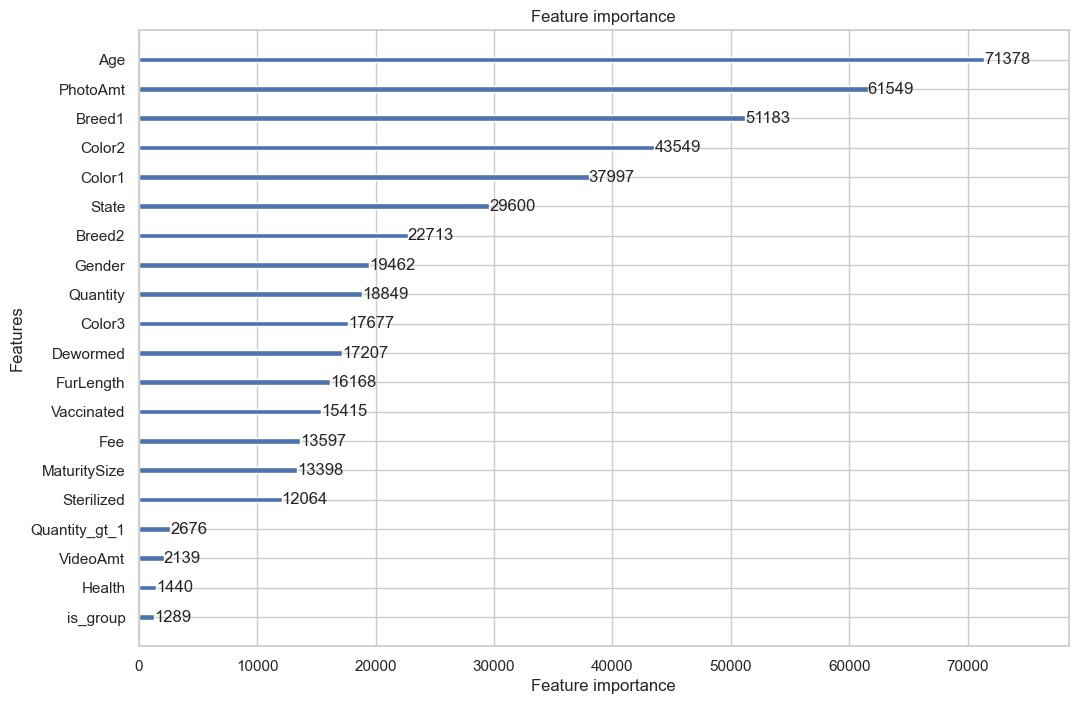

In [ ]:
#Visualizar la importancia de las características
lgb.plot_importance(lgb_model)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

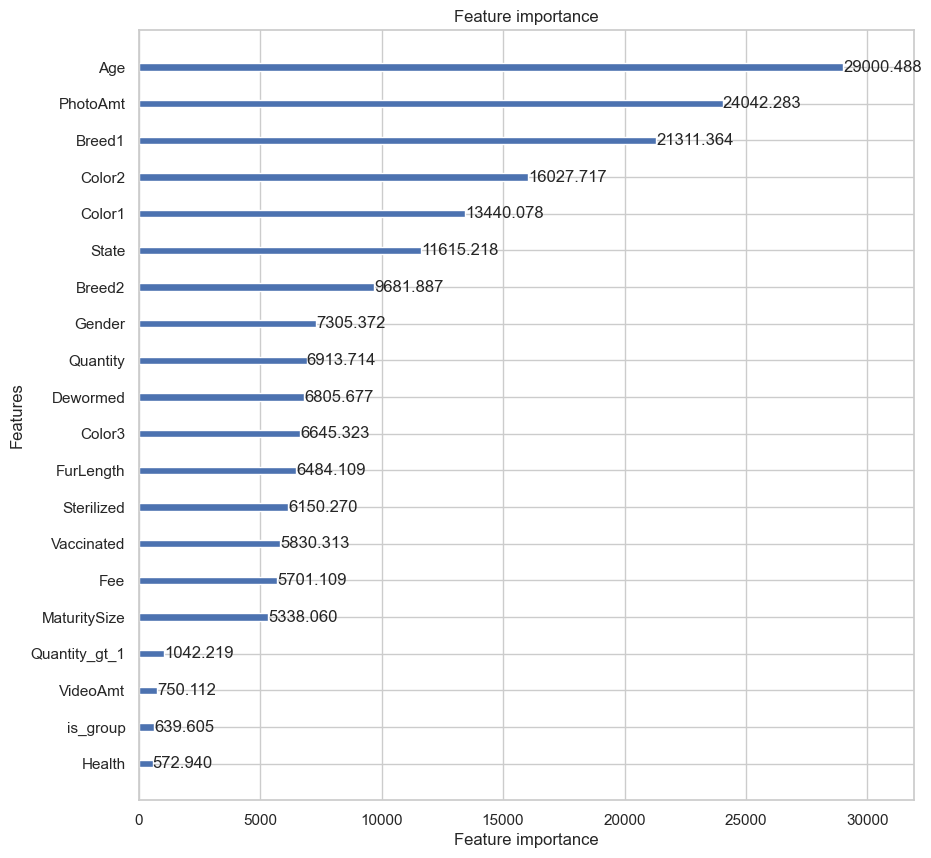

In [ ]:
lgb.plot_importance(lgb_model, importance_type='gain', figsize=(10,10), max_num_features=20)

## 9. Desarrollar modelo(s) datos no estructurados (Opcional)

## 10. Desarrollar modelo ensamblado (Opcional)

## 11. Valoración del modelo/conclusiones

Se logra una mejora menor en el indicador Kappa. 
